# Introduction

The following notebook analysis the fare price of flights and trains the model to predict such prices with the use of regressors. The file was taken from the publicly available repository: https://www.kaggle.com/datasets/nikhilmittal/flight-fare-prediction-mh

The motivation for such topic is the fact that I'm a globetrotter and whenever I plan my travels I use various websites, such as skyscanner, to check for deals. This task has been quite time consuming. Therefore, I thought that it might be a good exercise to perform such an analysis and maybe even train a model that could help me with my future travels in predicting the lowest fare, ergo best deals.

This is the final version of the notebook. This study was performed based on own knowledge, university material, articles and other projects publicly avaible on Kaggle.

In [1]:
# setting jupyter notebook cell to display multiple results.
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# importing display method from display module. This method displays a DataFrame. 
# In this notebook, it will be used to display a DataFrame by invoking functions and classes where the return value contains a different result.
# Thus, helps in reducing the complexity of coding by allowing to return multiple results from a function/class call.
from IPython.display import display

In [2]:
# importing pandas library for data analysis and manipulation.
import pandas as pd

# importing numpy library for working with arrays.
import numpy as np

# importing seaborn library - a high-level interface visualizations library.
import seaborn as sns
# importing statsmodels which is necessary for plotting a regression plot.
import statsmodels
# importing matplotlib for data visualization.
import matplotlib.pyplot as plt

# importing types for namespace assignment for attributes of a class.
import types
# importing statsmodels for the mean function. This supports the mean computation for a dictionary of values in one of the classes.
from statistics import mean

# importing classifiers and other data manipulation methods from machine learning library.
from sklearn.linear_model import LinearRegression as lin_reg, ElasticNet as elas_net
from sklearn.ensemble import HistGradientBoostingRegressor as gradboost_reg, RandomForestRegressor as rf_reg
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler as SC, PolynomialFeatures, LabelEncoder

# Data cleaning & feature engineering process

In [3]:
# data is loaded into a DataFrame.
df = pd.read_excel('Data_Train.xlsx')

# general data overview.
df.info()

# the first 5 records are displayed.
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


Airline Date_of_Journey    Source Destination                  Route  \
0       IndiGo      24/03/2019  Banglore   New Delhi              BLR → DEL   
1    Air India       1/05/2019   Kolkata    Banglore  CCU → IXR → BBI → BLR   
2  Jet Airways       9/06/2019     Delhi      Cochin  DEL → LKO → BOM → COK   
3       IndiGo      12/05/2019   Kolkata    Banglore        CCU → NAG → BLR   
4       IndiGo      01/03/2019  Banglore   New Delhi        BLR → NAG → DEL   

  Dep_Time  Arrival_Time Duration Total_Stops Additional_Info  Price  
0    22:20  01:10 22 Mar   2h 50m    non-stop         No info   3897  
1    05:50         13:15   7h 25m     2 stops         No info   7662  
2    09:25  04:25 10 Jun      19h     2 stops         No info  13882  
3    18:05         23:30   5h 25m      1 stop         No info   6218  
4    16:50         21:35   4h 45m      1 stop         No info  13302

The data is composed of one integer variable, that is the target variable price and 10 object variables, corresponding to 11 columns and 10683 records / rows.

The data is a register of flights that encompasses the airline, date of journey, source and destination with their route, the departure and arrival time, the route duration, total number of stops, additional info and price. 

In [4]:
# all column titles are converted to lowercase.
df.rename(columns = {'Airline':'airline','Date_of_Journey':'date_of_journey','Source':'source',
                     'Destination':'destination','Route':'route','Dep_Time':'dep_time',
                     'Arrival_Time':'arrival_time','Duration':'duration','Total_Stops':'total_stops',
                     'Additional_Info':'additional_info','Price':'price'}, inplace = True)

In [5]:
# sums all the missing values of every column.
df.isnull().sum()

airline            0
date_of_journey    0
source             0
destination        0
route              1
dep_time           0
arrival_time       0
duration           0
total_stops        1
additional_info    0
price              0
dtype: int64

According to the returned results, two missing values are found, one in total_stops and one in route.

Since the dataset is composed of 10683 records and the objective is to train a model for predicting flight prices, it would be safe to drop these missing values. In case of low record count or if the objective is associated with saving lives, then a consideration could be made.  

In [6]:
# removing missing values' records.
df.dropna(inplace = True)

# double-checking that there are no more missing values in the dataset.
df.isnull().sum()

airline            0
date_of_journey    0
source             0
destination        0
route              0
dep_time           0
arrival_time       0
duration           0
total_stops        0
additional_info    0
price              0
dtype: int64

In [7]:
# sums all the duplicated records.
df[df.duplicated()].value_counts().sum()

220

There are 220 duplicated records.

Again, since the data prediction is not related to a life threating situation, the duplicates can be removed. Especially, since it could have affect model training. 

In [8]:
# removing duplicated records.
df.drop_duplicates(keep='first',inplace=True)

# double-checking that there are no more duplicates in the dataset.
df[df.duplicated()].value_counts().sum()

0

Perfect!

It is time to analyse each variable thoroughly for further record removal or values modification. This is also known as feature engineering. 

Continous values or whatever represents a continous value will go first. Afterward, the categorical variables.

In [9]:
# displaying duration values.
df['duration'].value_counts()

2h 50m     544
1h 30m     386
2h 45m     335
2h 55m     332
2h 35m     329
          ... 
30h 25m      1
30h 15m      1
42h 5m       1
28h 55m      1
47h 40m      1
Name: duration, Length: 368, dtype: int64

The duration column contains values in string format of hours and minutes. With the to_timedelta method, these values can be extracted and afterward, transformed to seconds to later compute the total minutes of each flight with the division of seconds by 60. 

Afterward, these values will be reassigned to the duration column as integer.

In [10]:
# converting duration values and displaying the modified column.
df['duration'] = (pd.to_timedelta(df['duration']).dt.total_seconds() // 60).astype(int)

df["duration"].value_counts()

170     544
90      386
165     335
175     332
155     329
       ... 
1825      1
1815      1
2525      1
1735      1
2860      1
Name: duration, Length: 368, dtype: int64

Machine learning models work best with values. Thus, the above modified or engineered values can be better interpreted by the regressor. 

Similarly, the number of stops is given as a string, which can be easily replaced by an integer carrying the same information. 

In [11]:
# displaying total_stops values.
df['total_stops'].value_counts()

1 stop      5625
non-stop    3475
2 stops     1318
3 stops       43
4 stops        1
Name: total_stops, dtype: int64

In [12]:
# replacing the string values with integer values.
df['total_stops'].replace({'2 stops': 2,'3 stops': 3,'4 stops': 4,'1 stop': 1,
                           'non-stop':0}, inplace=True)

df['total_stops'].value_counts()

1    5625
0    3475
2    1318
3      43
4       1
Name: total_stops, dtype: int64

Now all continous values can be analysed together with the use of the describe method, which returns the count, mean, standard deviation, the minimum and maximum value, as well as the quartiles.

In [13]:
# a list is created with all the continous variables from the current DataFrame and afterward, these are assigned to continous_variable.
con_cols = list(df.select_dtypes(include=['float64','int64']).columns)
continuous_variables = df[con_cols]
# the describe method is invoked.
continuous_variables.describe()

duration   total_stops         price
count  10462.000000  10462.000000  10462.000000
mean     629.781591      0.802332   9026.790289
std      500.699045      0.660609   4624.849541
min        5.000000      0.000000   1759.000000
25%      170.000000      0.000000   5224.000000
50%      505.000000      1.000000   8266.000000
75%      910.000000      1.000000  12344.750000
max     2860.000000      4.000000  79512.000000

From the data, it can be noticed that there are outliers in each column.

In duration, 75% of the records are below 910, while the maximum value is 2860.

In total_stops, 75% of the records are below 1, while the maximum value is 4. 

Lastly, in price, 75% of records' price was below 12344, while the maximum price paid is 79512. 

These are definitely outliers. A boxplot can be used to visualize these outliers.

<Figure size 1000x1000 with 0 Axes>

<AxesSubplot:>

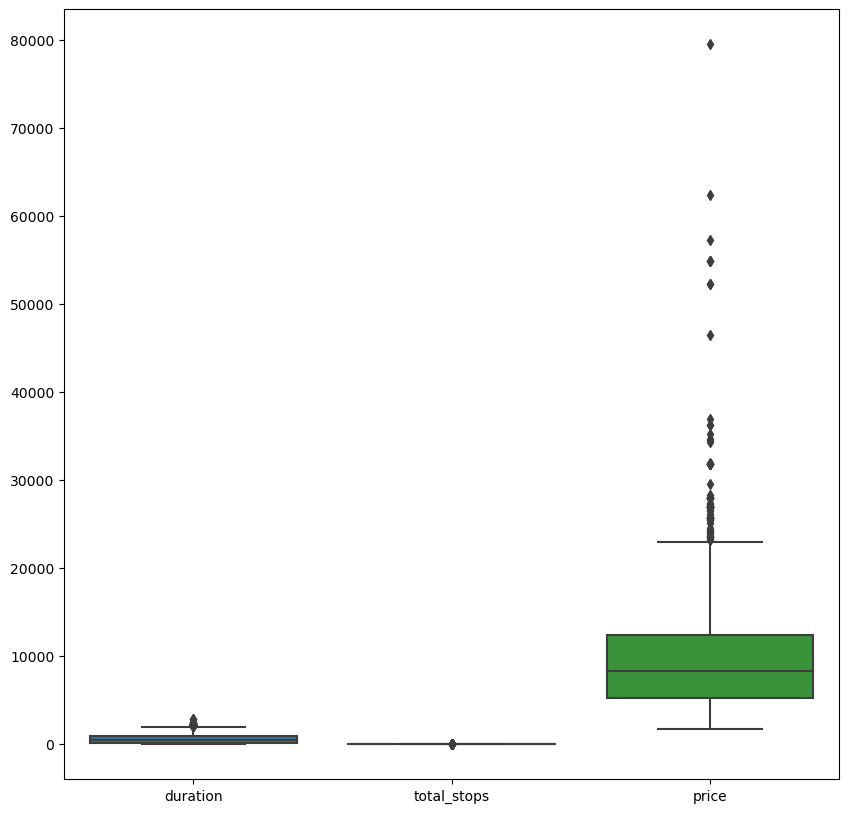

In [14]:
# visualizing outliers.
plt.figure(figsize=(10,10))
sns.boxplot(data=continuous_variables)

It is quite difficult to notice the outlier in total_stops since the data wasn't scaled and the datapoints magnitude is different in each variable. 

Albeit, in both duration and price, the outliers are noticeable. 

The Interquartile Range can help identify values that are considered as outliers. 

The basic formula is: Q3 + 1.5 x IQR for high outlier and Q1 - 1.5 x IQR for low outlier. 

The function below will be used to compute the high outlier, whereas with low outliers, the situation is different. 
Total_stops of 0 means a direct flight and there cannot be a value less than that. 

In terms of price, it is difficult to assess low outliers, since some companies might introduce promos, where the price could be considered a low outlier, but in actuality it isn't. 

Therefore, only the low outlier of duration can be found. 

However, the low bound will be purely based on news and information found on the internet, since duration of flights might be different depending on the source and destination. 

According to online sources, the shortest domestic flight in India is from: Guwahati to Silchar. Consequently, according to information found on skyscanner, the flight duration from Silchar to Guwahati is the shortest and it takes about 40 minutes. 

Therefore, whatever is below that should be considered an outlier. 

Link to the shortest flight information: https://www.moneycontrol.com/news/business/the-longest-and-shortest-routes-in-indian-skies-this-winter-9429351.html

Link to skyscanner search: https://www.skyscanner.pl/transport/loty/gau/ixs/230204/230211/?adultsv2=1&cabinclass=economy&childrenv2=&inboundaltsenabled=false&outboundaltsenabled=false&preferdirects=false&priceSourceId=&priceTrace=202301301655*D*GAU*IXS*20230204*spic*SG%7C202301301655*D*IXS*GAU*20230211*spic*SG&qp_prevCurrency=PLN&qp_prevPrice=335&qp_prevProvider=ins_month&rtn=1

In [15]:
# high outlier function.
def h_out(continuous_variables):
    for i in continuous_variables.columns:
        q1, q3 = np.percentile(df[i], 25), np.percentile(df[i], 75)
        iqr = q3 - q1
        res = q3 + 1.5 * iqr
        print(f'for the {i} column, the high outlier value starts at {res}')
    return

In [16]:
# invoking the high outlier function.
h_out(continuous_variables)

for the duration column, the high outlier value starts at 2020.0
for the total_stops column, the high outlier value starts at 2.5
for the price column, the high outlier value starts at 23025.875


In [17]:
# as observed above, whatever is greater than the values below is considered a high outlier. Similarly, a duration below 40 is infeasible.
len(df[df['duration'] > 2000])
len(df[df['duration'] < 40])
len(df[df['total_stops'] > 2])
len(df[df['price'] > 23000])

75

1

44

95

The number of outliers is quite low. Thus, the best solution would be to remove them, to avoid model bias caused by outliers.

In the following step, the source and destination values will be analysed with route. 

In [18]:
# displaying source, destination and route values.
df['source'].value_counts()

df['destination'].value_counts()

df['route'].value_counts()

Delhi       4345
Kolkata     2860
Banglore    2179
Mumbai       697
Chennai      381
Name: source, dtype: int64

Cochin       4345
Banglore     2860
Delhi        1265
New Delhi     914
Hyderabad     697
Kolkata       381
Name: destination, dtype: int64

DEL → BOM → COK          2376
BLR → DEL                1536
CCU → BOM → BLR           979
CCU → BLR                 724
BOM → HYD                 621
                         ... 
CCU → VTZ → BLR             1
CCU → IXZ → MAA → BLR       1
BOM → COK → MAA → HYD       1
BOM → CCU → HYD             1
BOM → BBI → HYD             1
Name: route, Length: 128, dtype: int64

According to the analysis, the destination New Delhi is basically Delhi, but written differently, since these are districts of Delhi. Thus, this was a typo by the registerar. 

In terms of the column route, it can be fully described by source and destination, since the most important classes are found in these columns. Whenever, a user wants to predict the price of a ticket, he or she will look into source and destination. 

Intermediate cities aren't that important unless the number of stops or duration is also taken into consideration, while purchasing a ticket.

In [19]:
# replacing New Delhi with Delhi.
df['destination'] = df['destination'].replace('New Delhi', 'Delhi')

# dropping route.
df = df.drop(['route'], axis = 1)

# double-checking destination after replacement.
df['destination'].value_counts()

Cochin       4345
Banglore     2860
Delhi        2179
Hyderabad     697
Kolkata       381
Name: destination, dtype: int64

In [20]:
# combining source and destination into a new column.
df['route'] = df['source'] + ' to ' + df['destination']
df['route'].value_counts()

Delhi to Cochin        4345
Kolkata to Banglore    2860
Banglore to Delhi      2179
Mumbai to Hyderabad     697
Chennai to Kolkata      381
Name: route, dtype: int64

The above values represent the count of flights between each city and the total number of flights in this dataset (after summation).

Before dropping the source and destination columns, median duration, mode of total_stops, average of price can be checked.

In [21]:
# grouping source and destination to present median of duration (middle value), mode of total_stops (most common value) and mean of price (average).
df.groupby(['source','destination'], as_index = False, observed = True)['duration'].agg(pd.Series.median).sort_values(by = 'duration', ascending=False)
df.groupby(['source','destination'], as_index = False, observed = True)['total_stops'].agg(pd.Series.mode).sort_values(by = 'total_stops', ascending=False)
df.groupby(['source','destination'], as_index = False, observed = True)['price'].mean().sort_values(by = 'price', ascending=False)

source destination  duration
3   Kolkata    Banglore     700.0
2     Delhi      Cochin     665.0
0  Banglore       Delhi     175.0
1   Chennai     Kolkata     140.0
4    Mumbai   Hyderabad      90.0

source destination  total_stops
2     Delhi      Cochin            1
3   Kolkata    Banglore            1
0  Banglore       Delhi            0
1   Chennai     Kolkata            0
4    Mumbai   Hyderabad            0

source destination         price
2     Delhi      Cochin  10461.600690
3   Kolkata    Banglore   9143.083566
0  Banglore       Delhi   8022.872877
4    Mumbai   Hyderabad   5059.708752
1   Chennai     Kolkata   4789.892388

As it turns out, there still might be values that are greater than the center values. However, these values will be within the acceptable range. Some values might be greater and some lower than the center. Removing more values could negatively affect the model.

<Figure size 1000x1000 with 0 Axes>

<AxesSubplot:>

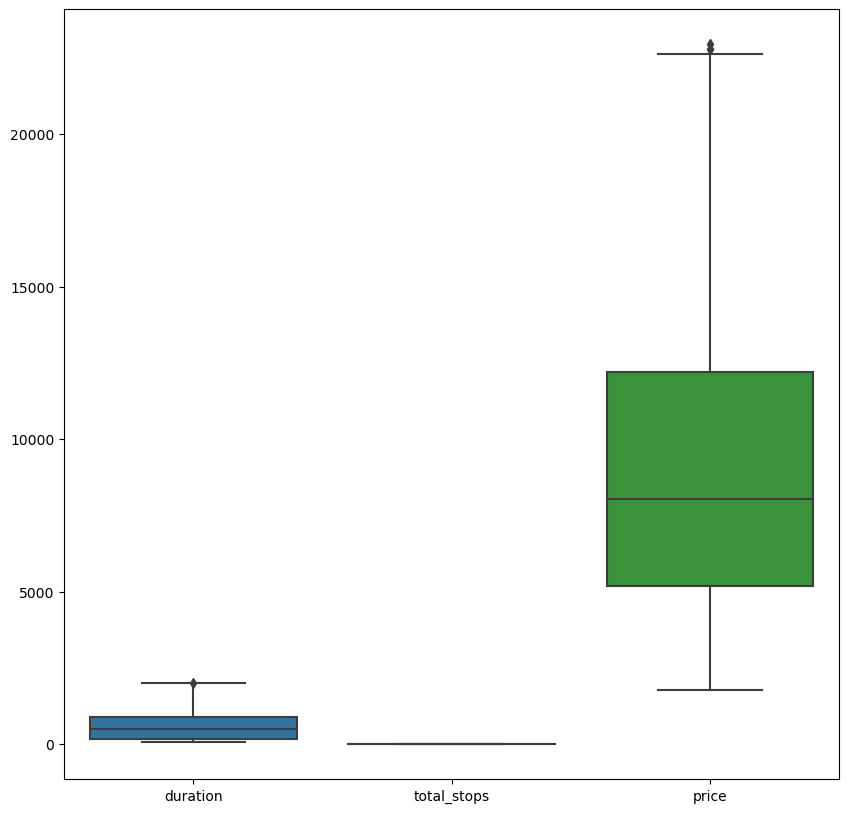

In [22]:
# the source & destination columns and outlier values are dropped.
df.drop(['source', 'destination'], axis=1, inplace=True)
df.drop(df[df.duration > 2000].index, inplace=True)
df.drop(df[df.duration < 40].index, inplace=True)
df.drop(df[df.total_stops > 2].index, inplace=True)
df.drop(df[df.price > 23000].index, inplace=True)

# double-checking outliers by revisualization.
cont_var = df[list(df.select_dtypes(include=['float64','int64']).columns)]
plt.figure(figsize=(10,10))
sns.boxplot(data=cont_var)

There are few outliers left, but these are very close to the acceptable range. 

Now its time for further categorical variable analysis. 

Source, destination and route was performed above. 

In the following sequence, dep_time, arrival_time, date_of_journey, airline and additional_info will be looked into.

In [23]:
# the values of dep_time and arrival_time will be displayed.
df['dep_time'].value_counts()

df['arrival_time'].value_counts()

18:55    233
17:00    225
07:10    201
07:05    198
10:00    193
        ... 
01:35      1
12:05      1
22:25      1
21:40      1
03:00      1
Name: dep_time, Length: 222, dtype: int64

19:00           412
21:00           355
19:15           332
16:10           151
12:35           122
               ... 
18:50 02 May      1
00:10 22 Mar      1
01:45 22 Mar      1
23:00 19 May      1
21:20 13 Mar      1
Name: arrival_time, Length: 1319, dtype: int64

The values are in string format of hour and minutes (in some cases, even the date and month). 

These will be converted to datetime and only the hour and minutes will be extracted, since the date and month can be found in date_of_journey.

Afterward, a new column will be created, arrival_day, in which the values same and next will be stored. These values represent the arrival day, whether the passenger arrived the same day as the day of departure or date_of_journey or if he or she arrived the next day. 

This is a quite important aspect for most passengers, since arrival by the next day would mostly mean that a passenger has to forgo two days in order to arrive to the destination. The day he or she has to depart and the day he arrives. Usually, the passenger has to invest a lot of time for preparing and arriving to the airport, as well as forgos the next day because of jet lag.

In [24]:
# the dep_time and arrival_time column records will be replaced with hours and minutes of their previous values.
departure = pd.to_datetime(df['dep_time']).dt.strftime('%H:%M')
df['dep_time'] = pd.to_datetime(departure)
arrival = pd.to_datetime(df['arrival_time']).dt.strftime('%H:%M')
df['arrival_time'] = pd.to_datetime(arrival)

If the duration is greater than 1440 minutes, it means greater than or equal to 24 hours. Ergo, this is a next day arrival. In case of flight durations below that, it depends on the departure and arrival time. 

An example of a departure time greater than arrival time is: 22:00 and arrival at 5:00. This is a next day arrival, and it matches the mathematical expression. In other cases, the arrival is the same day.

In [25]:
# a function that will create two classes: same and next for the arrival day.
def check(row):
    if row['duration'] >= 1440:
        return 'next'
    elif row['duration'] < 1440  and row['dep_time'] > row['arrival_time']:
        return 'next'
    else:
        return 'same'

In [26]:
# the following line will apply the above function and return the results.
df['arrival_day'] = df.apply (lambda row: check(row), axis=1)
df['arrival_day'].value_counts()

same    6261
next    4001
Name: arrival_day, dtype: int64

In [27]:
# the arrival_day describes the below columns. Thus, these will be removed.
df.drop(['dep_time', 'arrival_time'], axis=1, inplace=True)

In [28]:
# displays airline values.
df['airline'].value_counts()

Jet Airways                          3612
IndiGo                               2043
Air India                            1607
Multiple carriers                    1178
SpiceJet                              814
Vistara                               478
Air Asia                              319
GoAir                                 194
Multiple carriers Premium economy      13
Vistara Premium economy                 3
Trujet                                  1
Name: airline, dtype: int64

The least common three values will be assigned as Other, to simplify interpretation and reduce multi-collinearity.

In [29]:
# values are replaced and airline is redisplayed.
df['airline'].replace({'Multiple carriers Premium economy':'Other',
                       'Vistara Premium economy':'Other','Trujet':'Other'}, inplace=True)

df['airline'].value_counts()

Jet Airways          3612
IndiGo               2043
Air India            1607
Multiple carriers    1178
SpiceJet              814
Vistara               478
Air Asia              319
GoAir                 194
Other                  17
Name: airline, dtype: int64

In [30]:
# date_of_journey values are displayed.
df['date_of_journey'].value_counts()

6/06/2019     488
18/05/2019    485
9/06/2019     480
12/06/2019    480
21/05/2019    479
9/05/2019     462
21/03/2019    403
15/05/2019    398
27/05/2019    368
27/06/2019    337
24/06/2019    328
1/06/2019     328
3/06/2019     325
15/06/2019    312
24/03/2019    309
24/05/2019    285
6/03/2019     285
27/03/2019    282
6/05/2019     279
1/05/2019     273
12/05/2019    257
1/04/2019     254
3/03/2019     202
9/03/2019     193
15/03/2019    160
18/03/2019    151
12/03/2019    134
9/04/2019     124
3/04/2019     110
21/06/2019    109
18/06/2019    105
6/04/2019     100
09/03/2019     99
06/03/2019     94
27/04/2019     94
24/04/2019     92
3/05/2019      90
15/04/2019     89
03/03/2019     87
21/04/2019     82
01/03/2019     79
18/04/2019     67
12/04/2019     63
1/03/2019      41
Name: date_of_journey, dtype: int64

The dates above can be simplified into three classes: peak season, off-season and shoulder-season. 

Peak season is when everyone wants to travel — high demand and prices.

Off-season, planes take off with empty seats, hotels are filled with empty beds and the travel industry as a collective lowers prices to increase demand.

Shoulder-season is between these two, where the demand is moderate.

According to online sources, there are two seasons in Indian travel industry: peak starting from 1st of October till 31st of March, and off from 1st of April till 30th of September.

Links to travel seasons in India:
1. https://indiasomeday.com/en/travelling-to-india-during-off-season-time/
2. https://www.tourism-of-india.com/best-time-to-visit-india/

In [31]:
# the date_of_journey column values will be converted to datetime format and the date and month are extracted.
df['date_of_journey'] = pd.to_datetime(df['date_of_journey'],format='%d/%m/%Y').dt.strftime('%d/%m')

# the conditions are created and assigned to these two variables.
season_range = [(df['date_of_journey'] >= '01/10') & (df['date_of_journey'] <= '31/03'),
                (df['date_of_journey'] >= '01/04') & (df['date_of_journey'] <= '30/09')]
season_category = ['peak season', 'off-season']

# the date_of_journey column is updated with these values.
df['date_of_journey']=np.select(season_range,season_category)
# the records dating 01/03 weren't updated accordingly.
# This was discovered during previous analysis of the data, which took place before completing this notebook.
df['date_of_journey'] = df['date_of_journey'].replace('0', 'peak season')

# the following line will print the values and sort them alphabetically.
season_rn = df["date_of_journey"].value_counts()
season_rn.iloc[np.argsort(season_rn.index)]

off-season      855
peak season    9407
Name: date_of_journey, dtype: int64

In [32]:
# displaying additional_info values.
df['additional_info'].value_counts()

No info                         8008
In-flight meal not included     1918
No check-in baggage included     318
1 Long layover                     9
Change airports                    5
No Info                            3
Red-eye flight                     1
Name: additional_info, dtype: int64

The classes will be reduced to 5, namely No info, In-flight meal not included, No check-in baggage included, Layover and Other.

This is done to simplify interpretation and reduce multi-collinearity.

In [33]:
# this will replace the values.
df['additional_info'].replace({'Red-eye flight':'Other', 'Change airports':'Other','1 Long layover':'Layover','No Info':'No info'}, inplace=True)

# redisplaying values.
df['additional_info'].value_counts()

No info                         8011
In-flight meal not included     1918
No check-in baggage included     318
Layover                            9
Other                              6
Name: additional_info, dtype: int64

In [34]:
# after cleaning and modifying all the categorical features, they will be assigned as type category.
obj_cols = list(df.select_dtypes('object').columns)
df[obj_cols] = df[obj_cols].astype('category')

In [35]:
df.info()

df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10262 entries, 0 to 10682
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   airline          10262 non-null  category
 1   date_of_journey  10262 non-null  category
 2   duration         10262 non-null  int64   
 3   total_stops      10262 non-null  int64   
 4   additional_info  10262 non-null  category
 5   price            10262 non-null  int64   
 6   route            10262 non-null  category
 7   arrival_day      10262 non-null  category
dtypes: category(5), int64(3)
memory usage: 371.8 KB


airline date_of_journey  duration  total_stops additional_info  price  \
0       IndiGo     peak season       170            0         No info   3897   
1    Air India      off-season       445            2         No info   7662   
2  Jet Airways     peak season      1140            2         No info  13882   
3       IndiGo     peak season       325            1         No info   6218   
4       IndiGo     peak season       285            1         No info  13302   

                 route arrival_day  
0    Banglore to Delhi        next  
1  Kolkata to Banglore        same  
2      Delhi to Cochin        next  
3  Kolkata to Banglore        same  
4    Banglore to Delhi        same

After cleaning the data, it is time for the exploratory data analysis phase.

# Exploratory Data Analysis

In [36]:
# the following function will display each column separately as a countplot.
def count_plot(fts):
    for feature in fts:
        plt.figure(figsize=(12,6))
        sns.countplot(x=feature, data=df)
        plt.show()

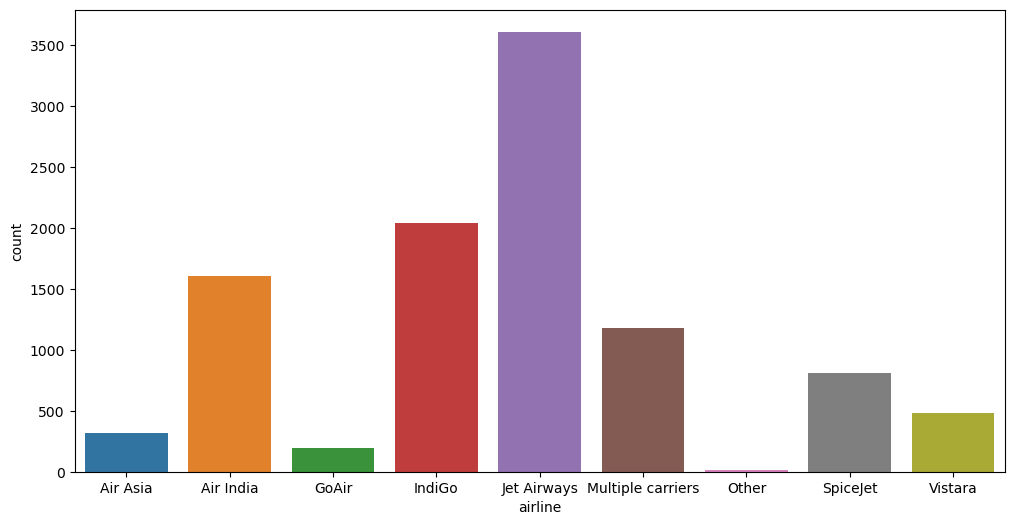

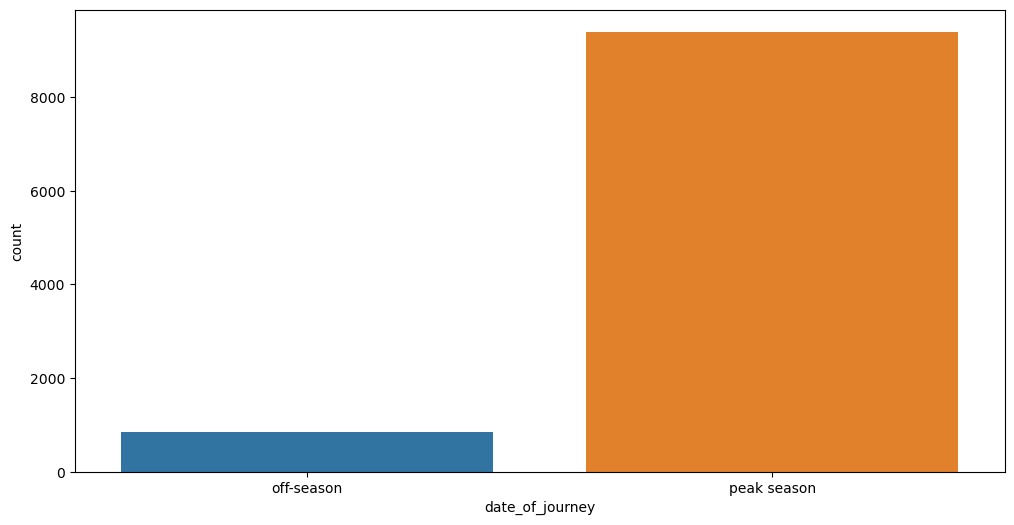

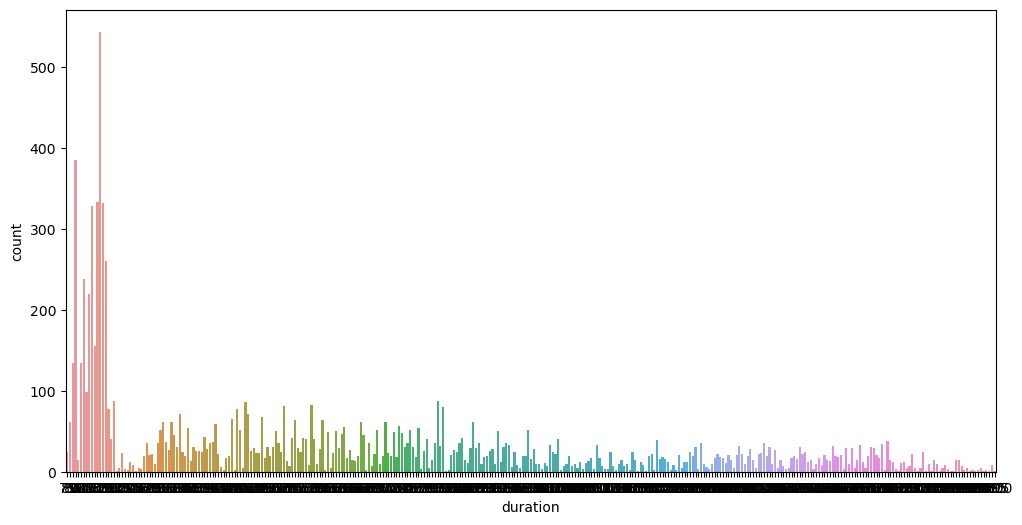

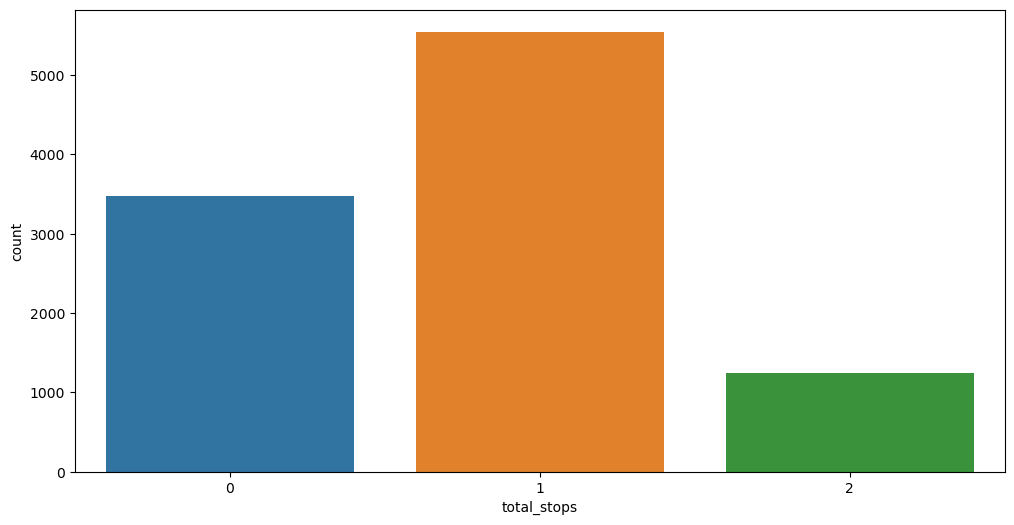

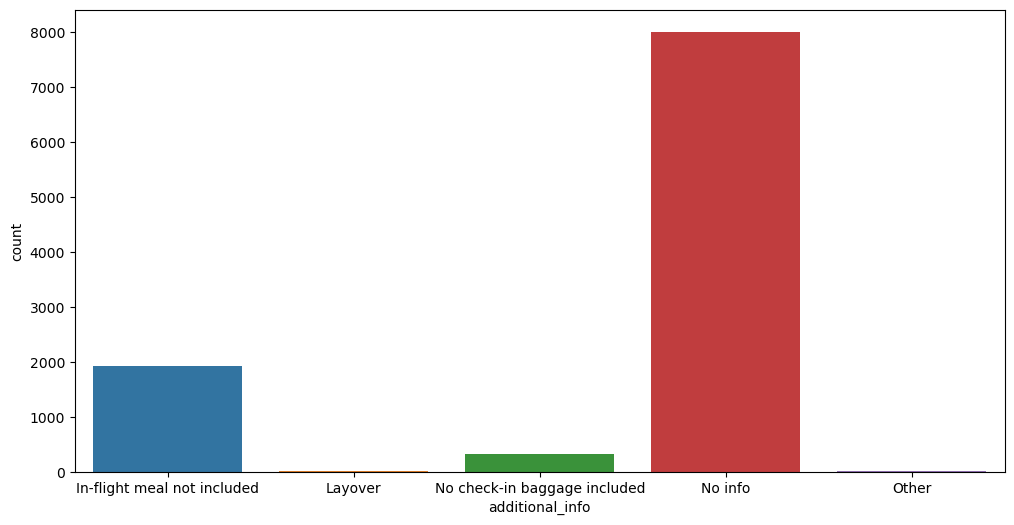

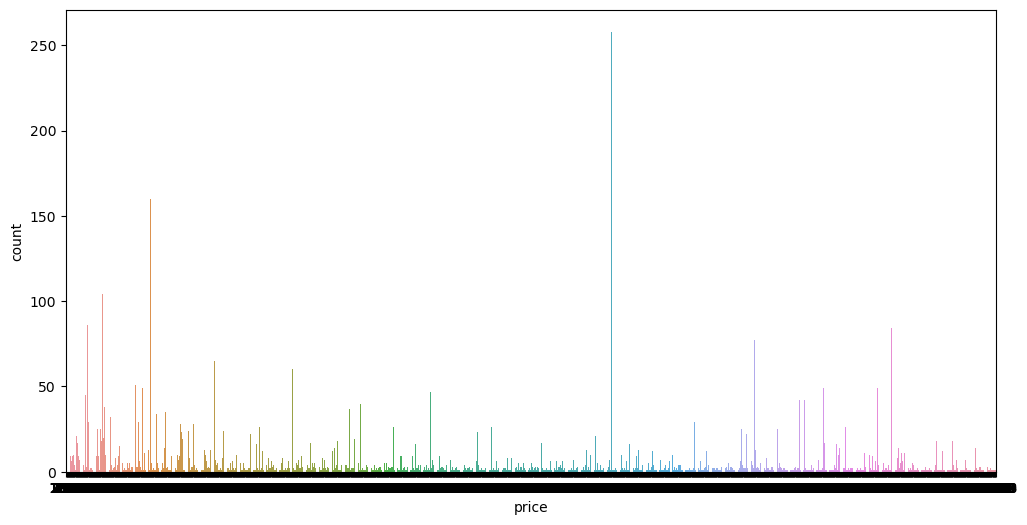

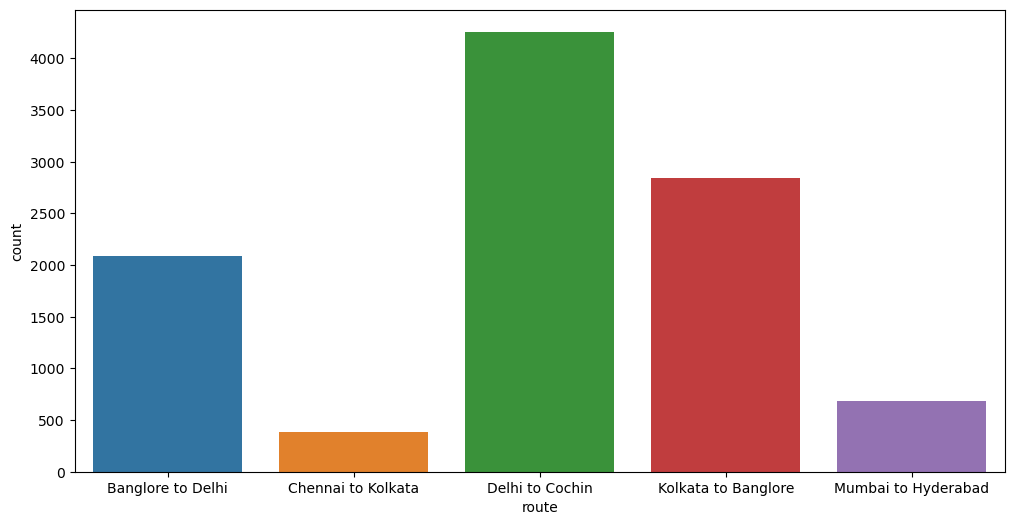

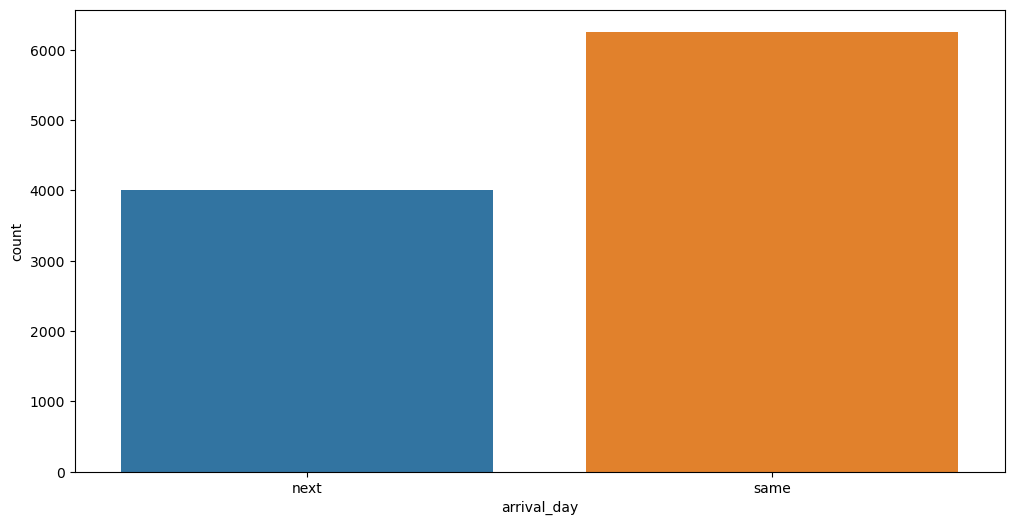

In [37]:
# this code will invoke the function.
fts = df.columns
count_plot(fts)

The most common airlines are Jet Airways, IndiGo and Air india, where they represent around 80% of the flights.

Most of the flights, around 90% were during peak season.

Most of the flights were short duration. Thus, the passengers either chose to travel close to their source city or choose flights with the least amount of stops.

This is further confirmed by the total_stops graph, where direct and 1 stop flights were most common. In some cases, there are no direct flights between two cities and therefore, the 1 stop flights count can be related to this condition.

In terms of additional info, the No info value was most common. Ergo, not much can be deduced from this column.

The prices are sparse, but highest concentration is at lower prices and those a bit higher than the median price.

The most common destinations were Delhi to Cochin, Kolkata to Banglore and Banglore to Delhi. Therefore from the capital and north-east to south of India and from the south to the capital.

Around 60% of flights arrived the same day. 

In [38]:
# the following function will display a boxplot/barplot of each feature and the target variable.
def box_plot(fts):
    for feature in fts:
        plt.figure(figsize=(15,10))
        if feature != 'duration':
            sns.boxplot(x=df[feature],y=df['price'],palette='hls')
        else:
            sns.barplot(x=df[feature],y=df['price'],palette='hls')
        plt.show()

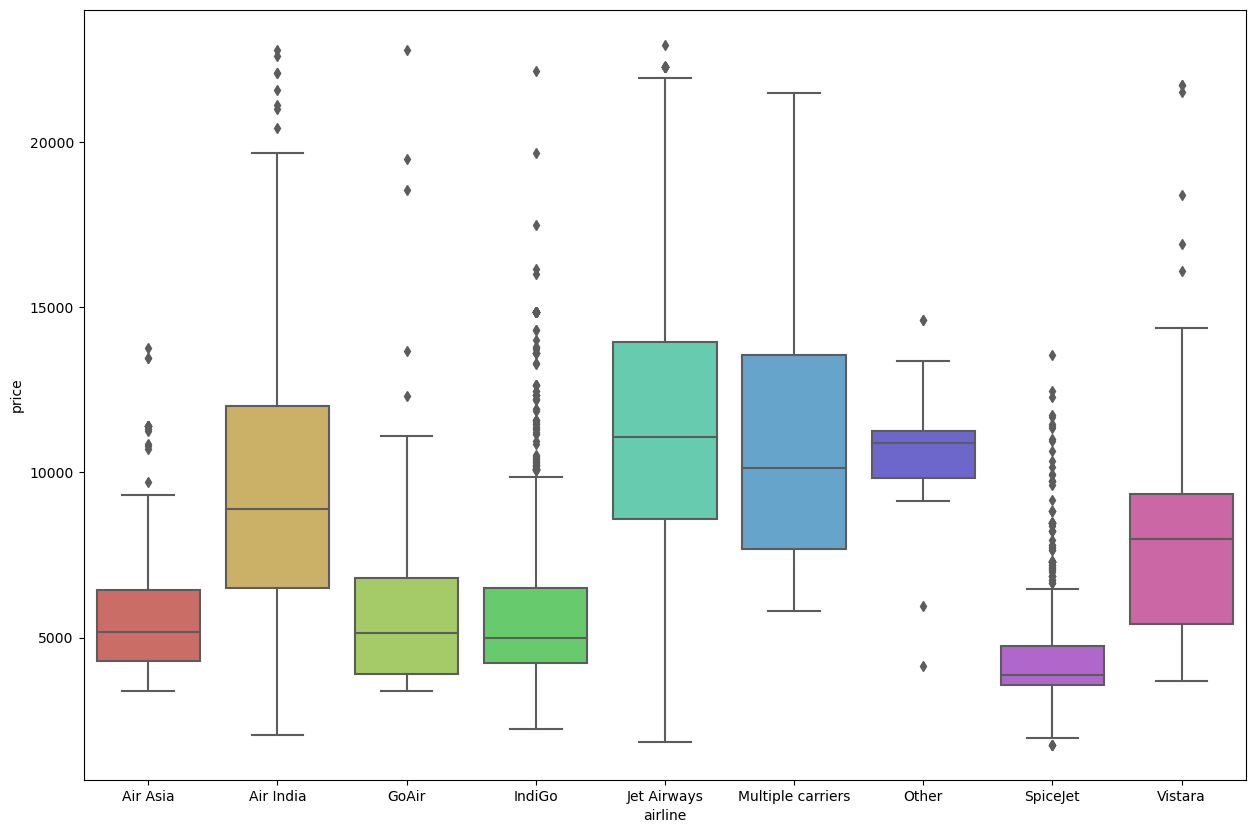

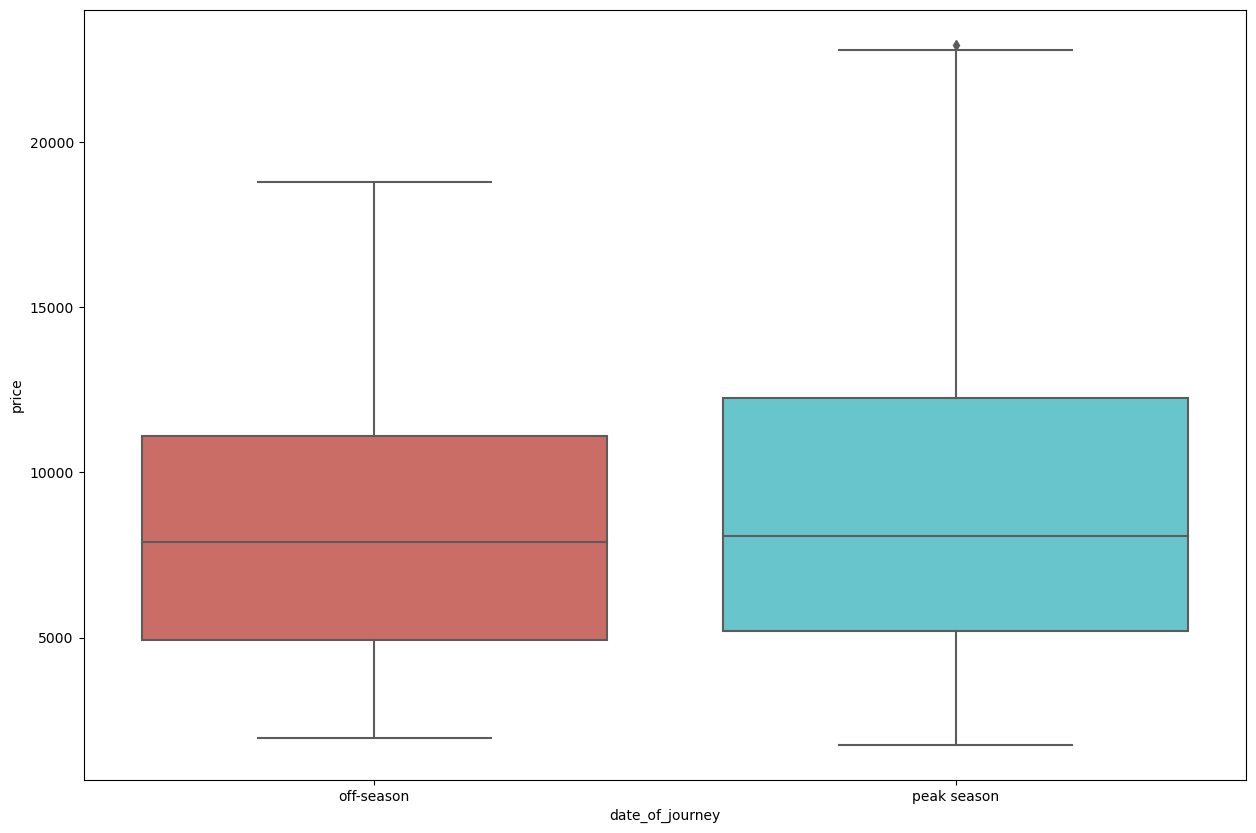

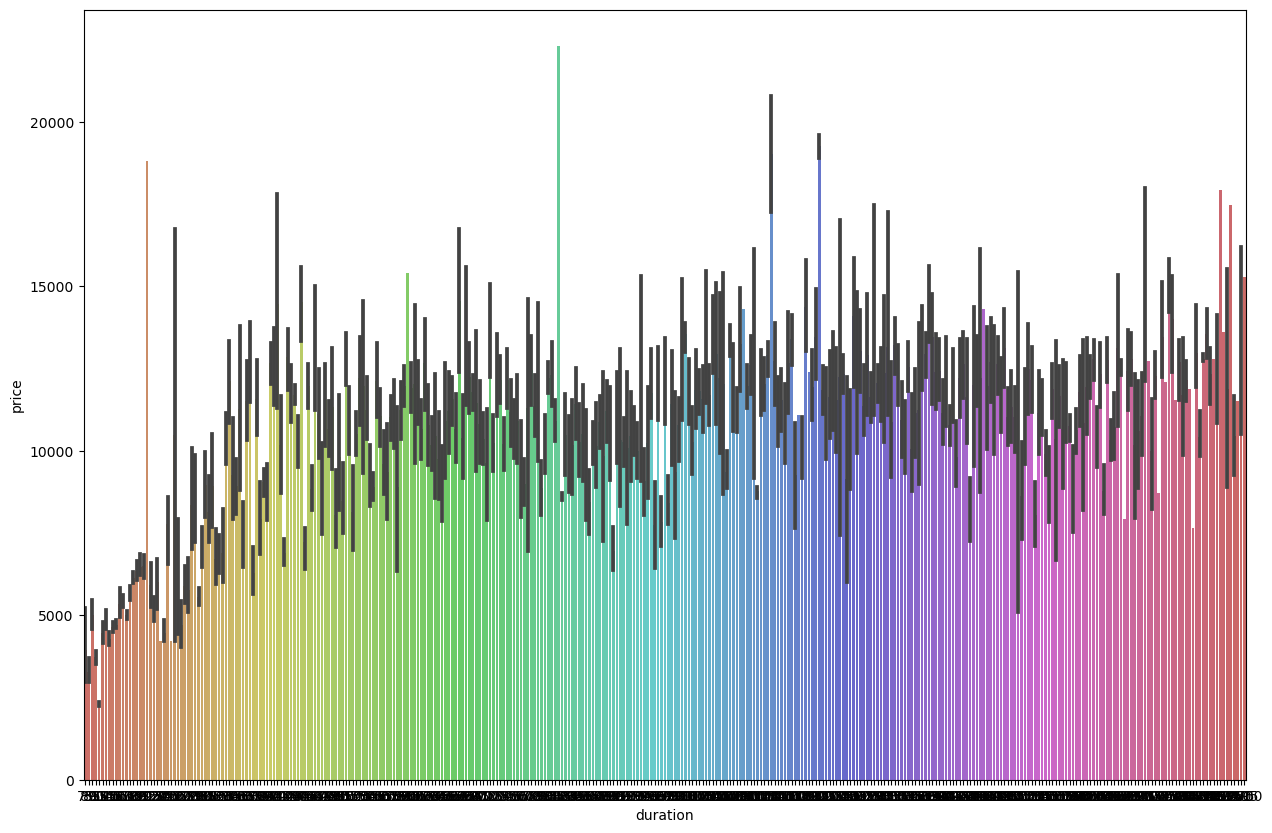

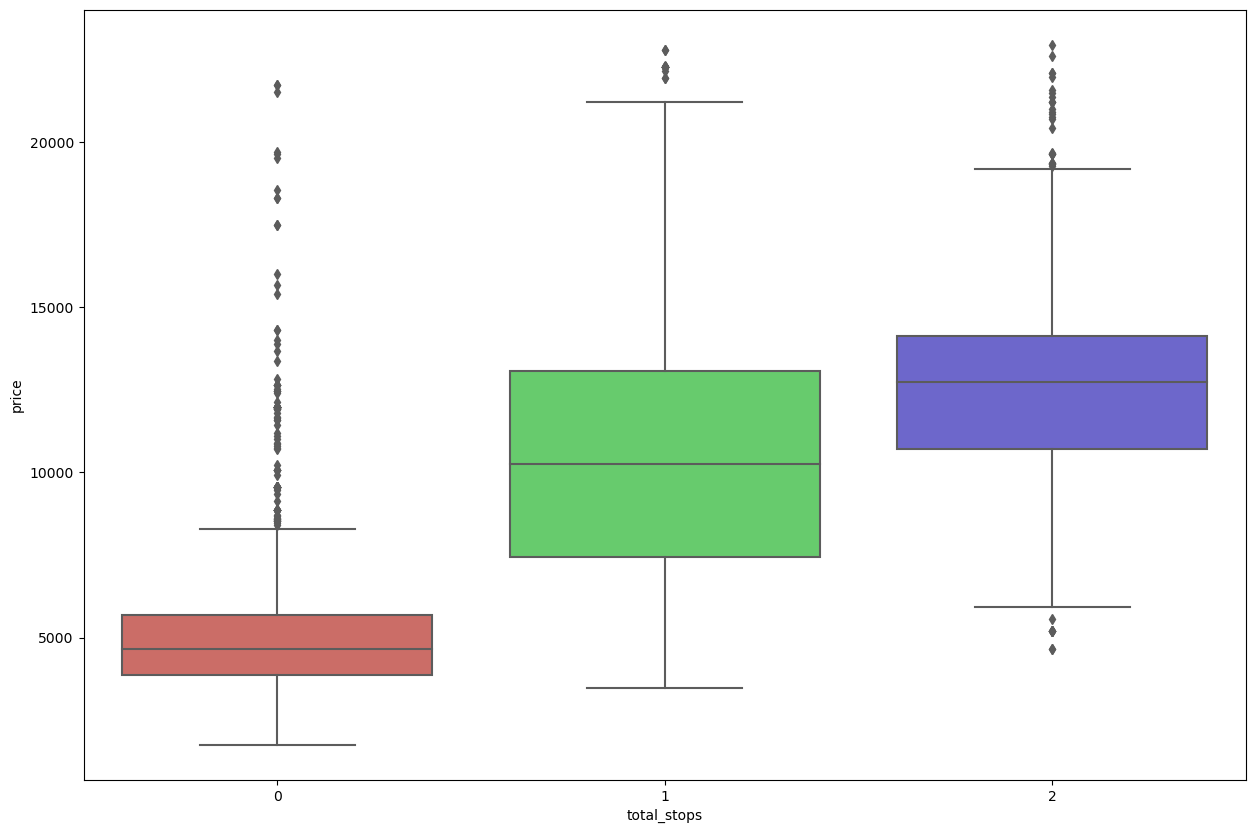

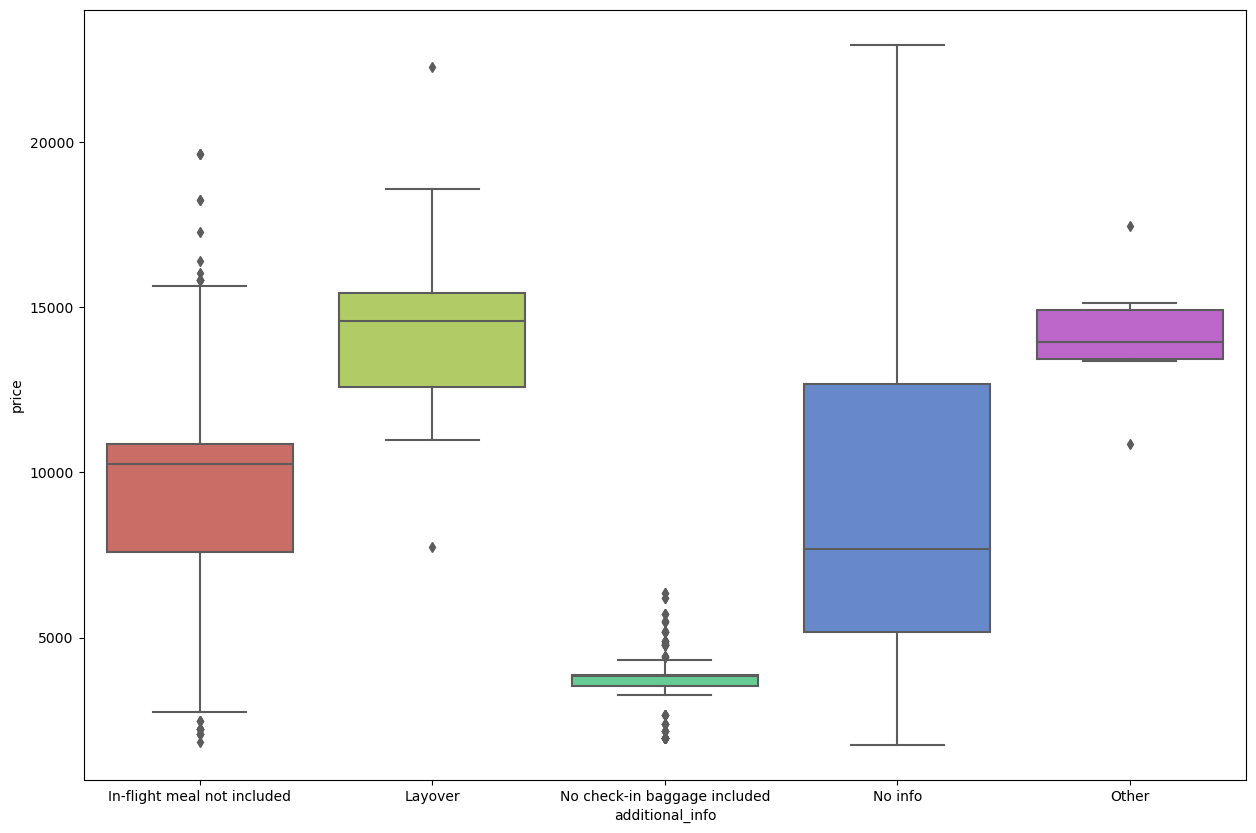

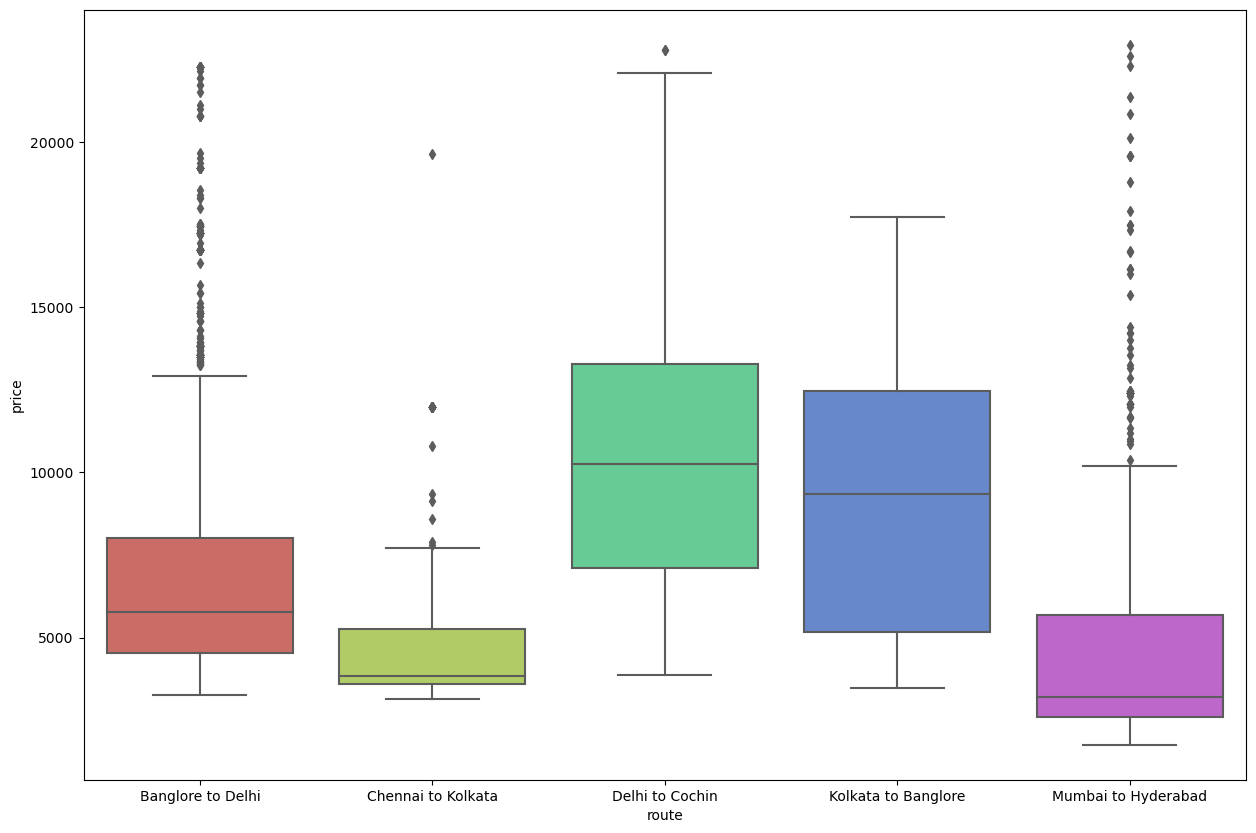

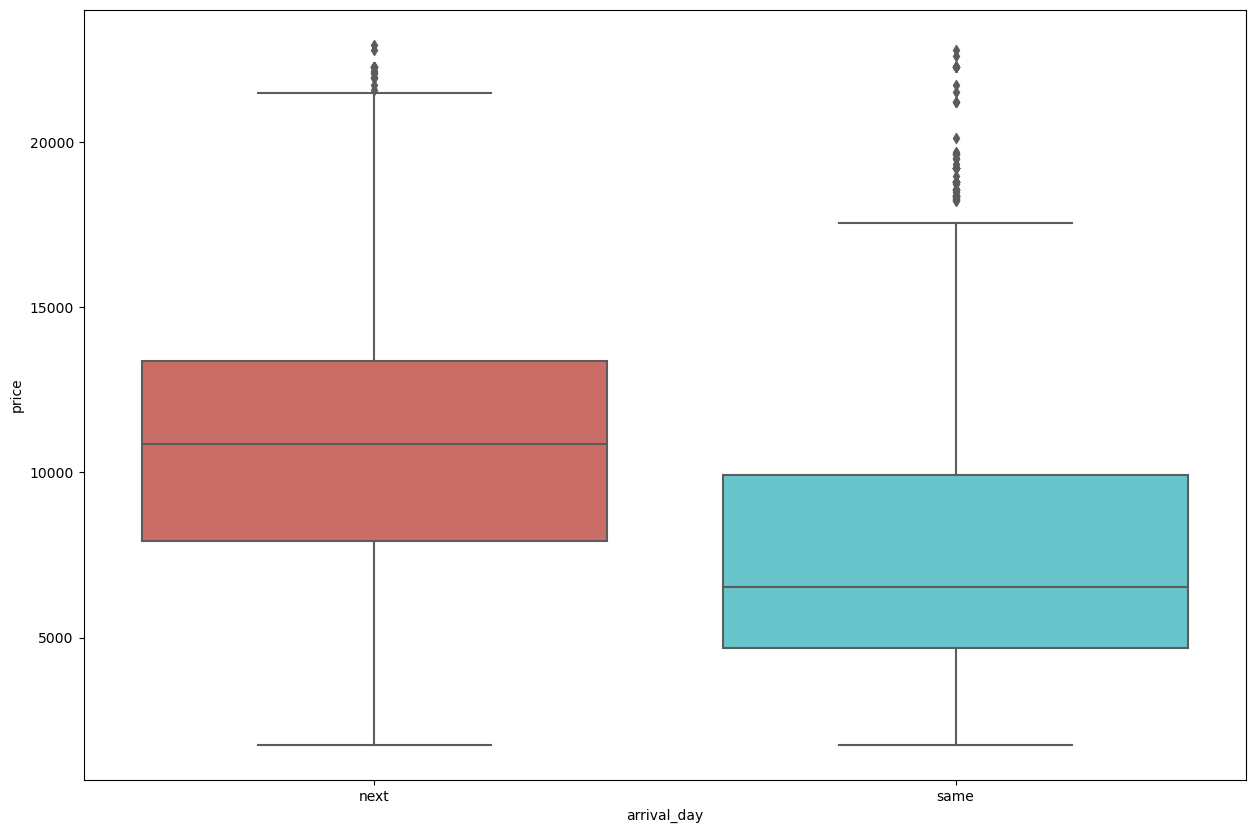

In [39]:
# the target variable is dropped, since the features are compared against it in the above function.
features = df.columns.drop(['price'])

# the function is invoked.
box_plot(features)

The highest price variability can be found in Air India, Jet Airways and Multiple carriers. These also represent the highest prices in the dataset.

In terms of date_of_journey, the highest variability and price is found within peak season.

It is clearly noticeable that the price increases with duration, although to a certain point.

Highest price variability is with 1 stop flights and no info.

Lastly, the highest price variability can be found in the route Kolkata to Banglore, which is from north-east of India to the south. In terms of arrival_day, next day is more expensive which can be explained by duration and the total number of stops.

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

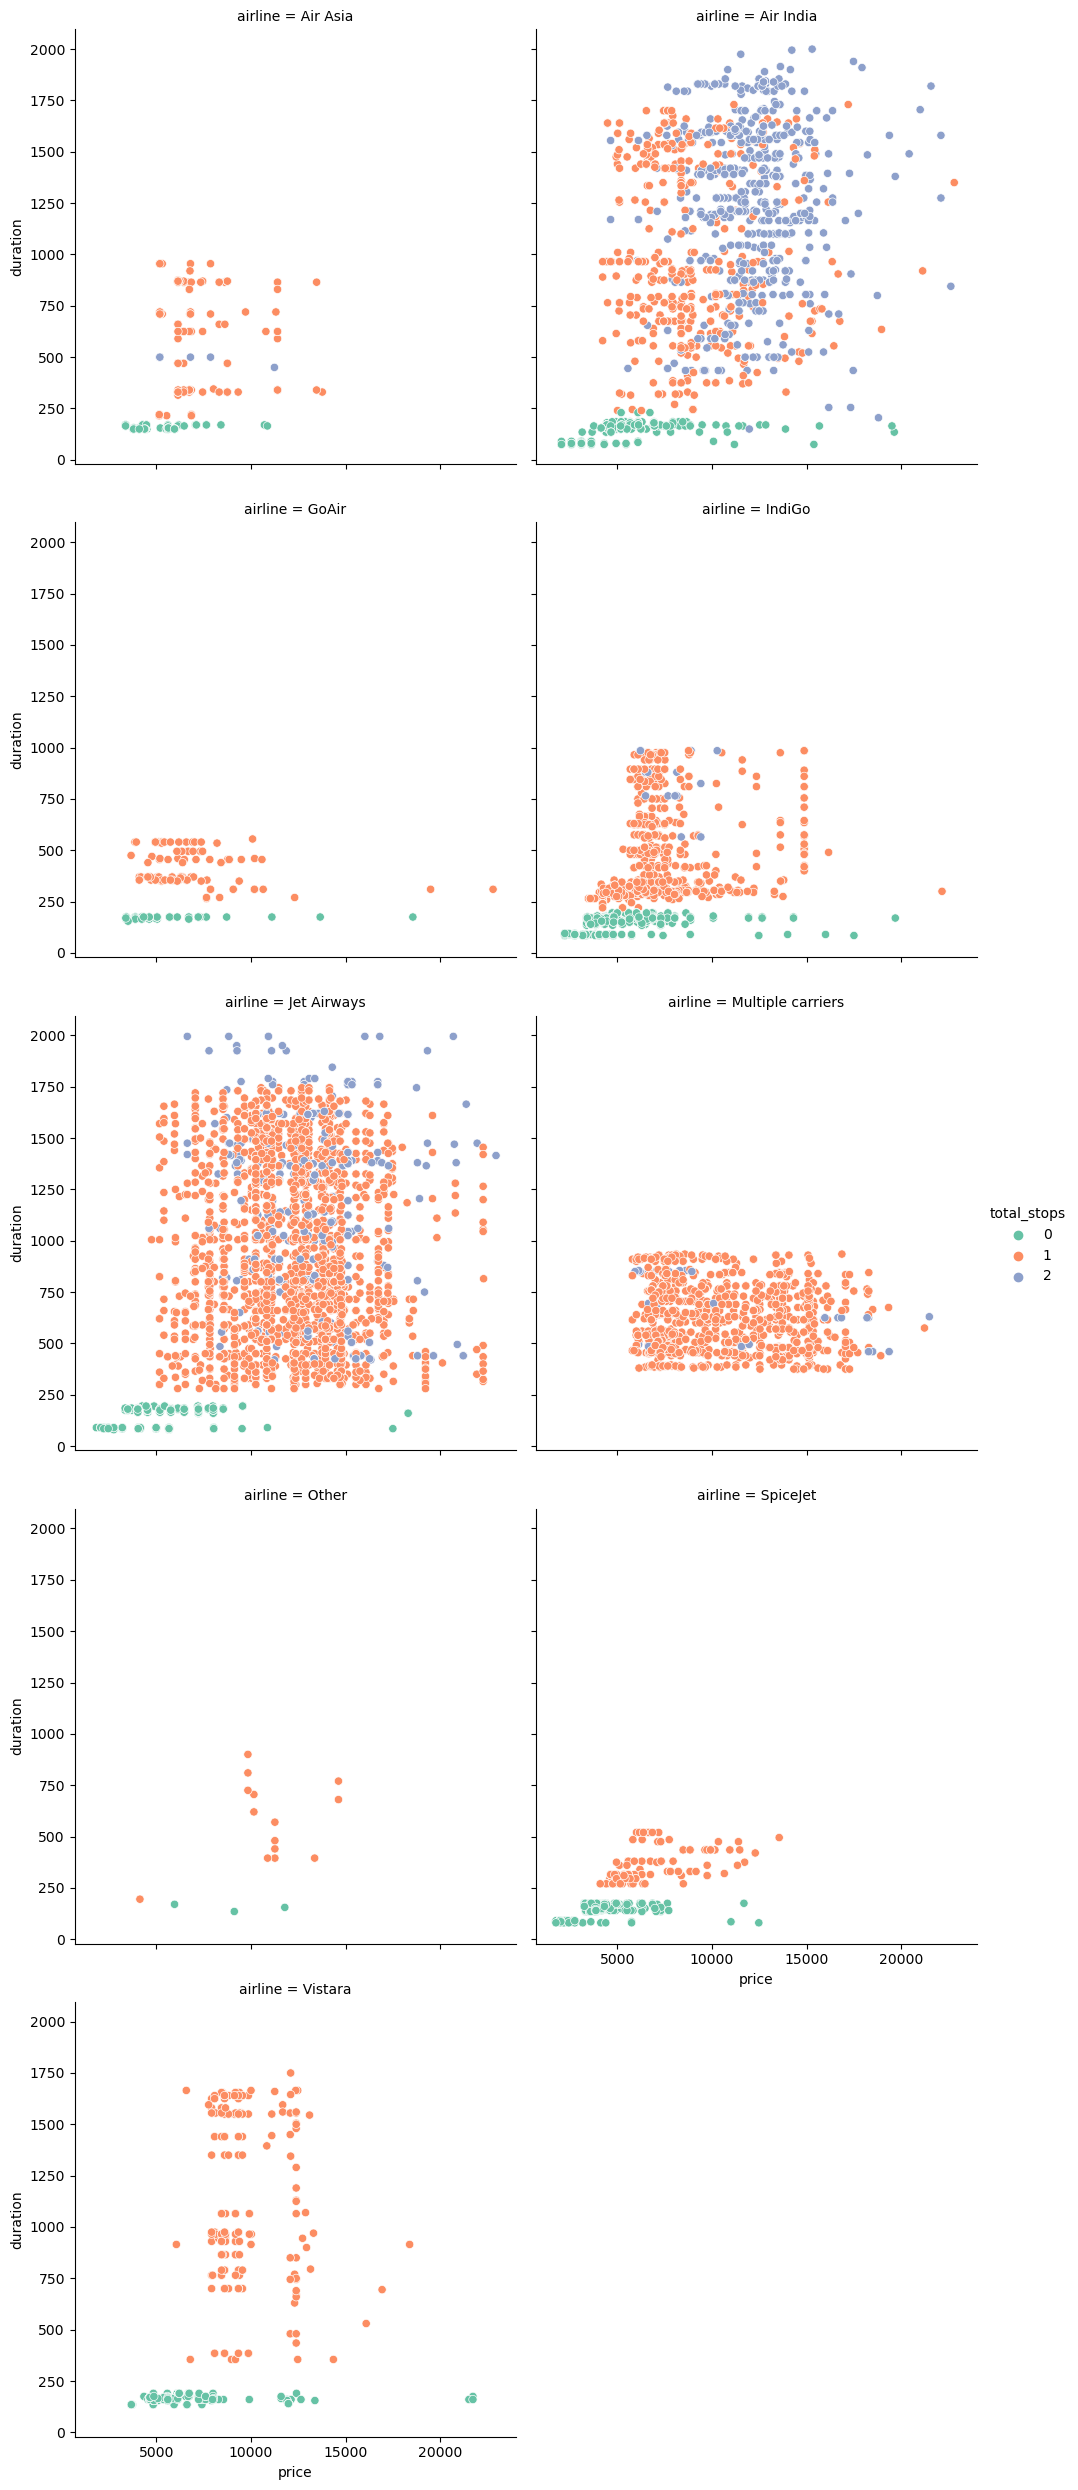

In [40]:
# the following plot will combine the target variable with duration, total_stops and each airline
plt.figure(figsize=(15,10))
sns.relplot(data=df, x = 'price', y='duration', hue = 'total_stops', col = 'airline', col_wrap = 2, palette='Set2')

IndiGo airline is the one affected the most by duration and total_stops. 

Other airlines are either slightly affected or their results are mixed. 

On top of that, some are limited to two classes of total_stops.

Label encoding will be used to encode categorical variables instead of OneHotEncoding, since OneHotEncoding produces high dimensionality and by applying PCA, the model won't gain anything, besides more complicated rotation of binary data. 

This could negatively impact model training. Therefore, the other is dropped for the avoidance of multicollinearity.

Link to an article about OneHotEncoding and PCA: https://andrewpwheeler.com/2021/06/22/pca-does-not-make-sense-after-one-hot-encoding/

In [41]:
# a copy of the DataFrame is created and the encoder is invoked.
mod_df = df.copy()
enc = LabelEncoder()

# each categorical variable is transformed/encoded into integers representing each class.
mod_df['airline'] = enc.fit_transform(df['airline'])
mod_df['date_of_journey'] = enc.fit_transform(df['date_of_journey'])
mod_df['additional_info'] = enc.fit_transform(df['additional_info'])
mod_df['route'] = enc.fit_transform(df['route'])
mod_df['arrival_day'] = enc.fit_transform(df['arrival_day'])

# the modified DataFrame is displayed.
mod_df

airline  date_of_journey  duration  total_stops  additional_info  \
0            3                1       170            0                3   
1            1                0       445            2                3   
2            4                1      1140            2                3   
3            3                1       325            1                3   
4            3                1       285            1                3   
...        ...              ...       ...          ...              ...   
10678        0                1       150            0                3   
10679        1                1       155            0                3   
10680        4                1       180            0                3   
10681        8                1       160            0                3   
10682        1                1       500            2                3   

       price  route  arrival_day  
0       3897      0            0  
1       7662      3            1  
2      13882      2            0  
3       6218      3            1  
4      13302      0            1  
...      ...    ...          ...  
10678   4107      3            1  
10679   4145      3            1  
10680   7229      0            1  
10681  12648      0            1  
10682  11753      2            1  

[10262 rows x 8 columns]

Now that the data has been encoded, it will be easier to interpret it with a correlation-heat map.

<Figure size 1800x1800 with 0 Axes>

<AxesSubplot:>

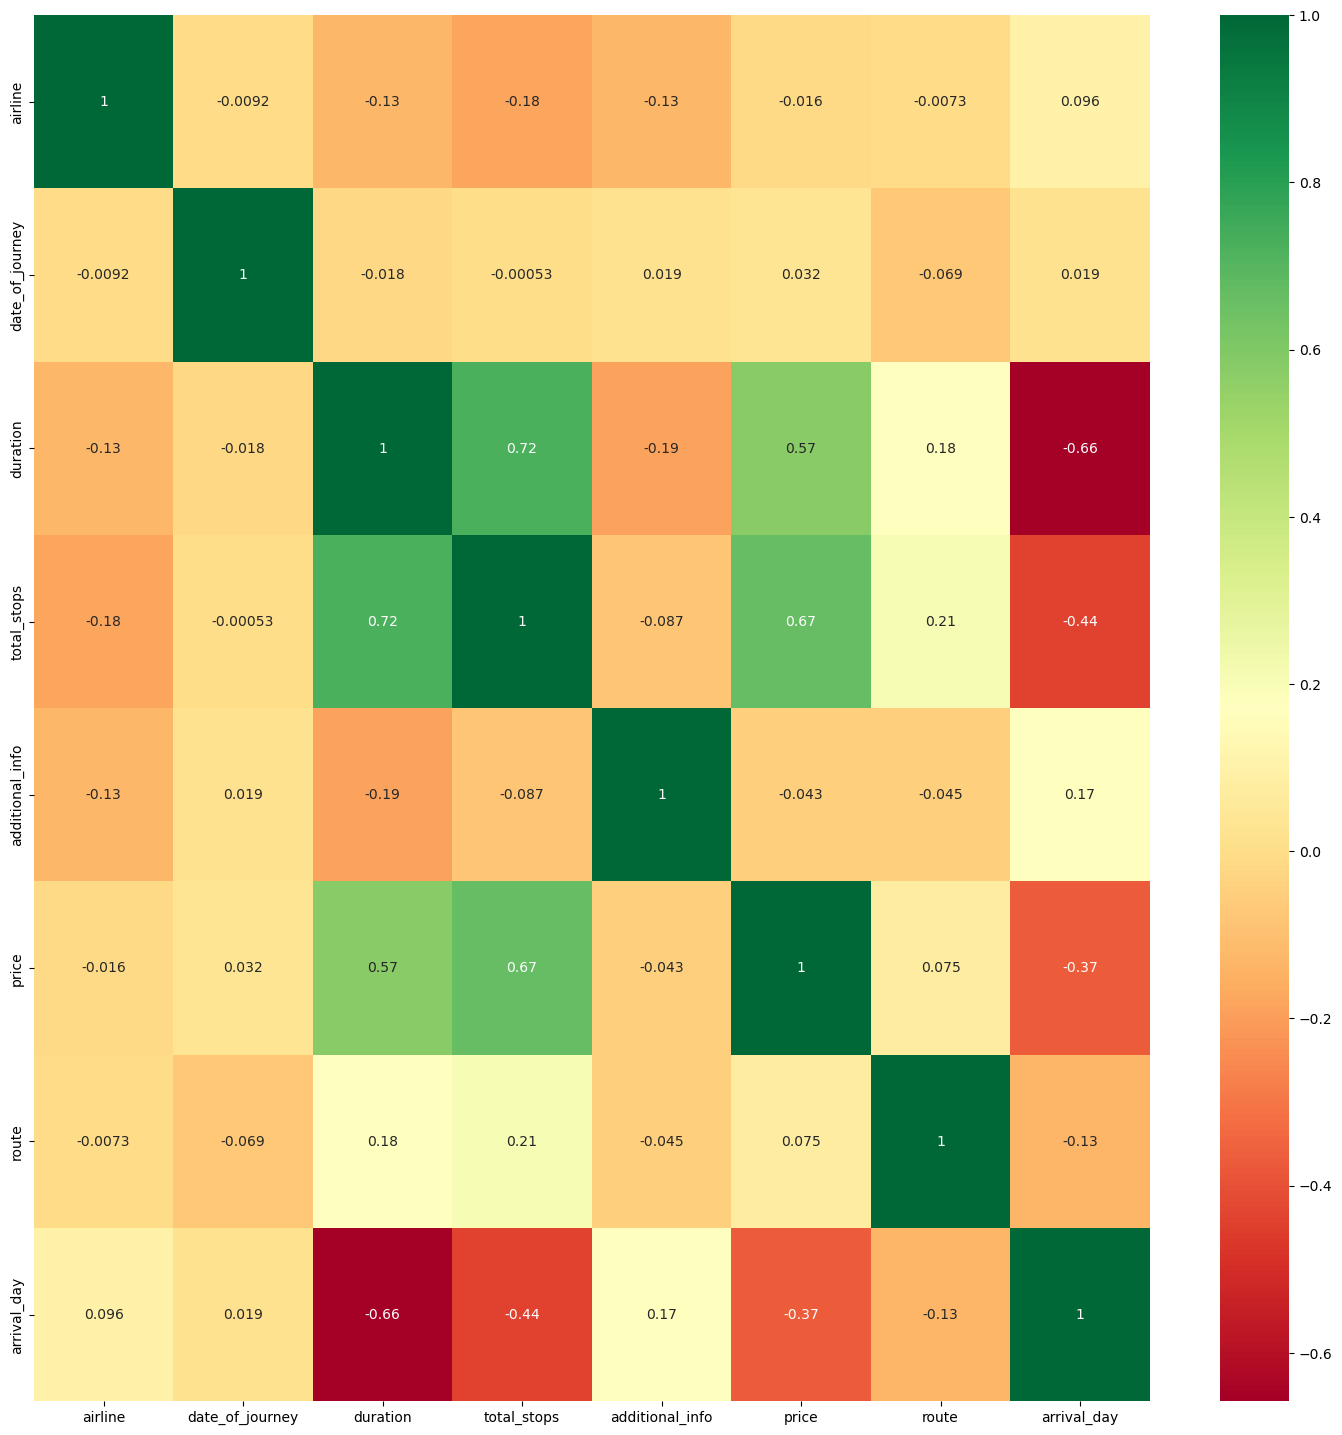

In [42]:
# this will display a heat-map of the correlation between the variables.
plt.figure(figsize = (18,18))
sns.heatmap(mod_df.corr(), annot = True, cmap = 'RdYlGn')
plt.show()

The value of 0 in arrival date is next day, while 1 is same day. Label encoder encodes each class alphabetically. 

Therefore, a negative correlation between arrival_day and duration / total_stops is because, the higher the number of arrival_day (1 = same) means lower value of duration and total_stops (inverse relationship).

There is a positive-strong correlation between duration, total_stops and price, since with increased number of stops, there will be an increase in duration and price. 

The strongest relationship between the target variable price is with total_stops, afterward duration and at last with arrival_day.

# Model training - Linear Regression

The best form of model training of price prediction is regression. Therefore, the following data will be fitted with various regressors. 

Firstly, the model will be fitted with linear regression with various modifications, returning around 8 models.

Linear regression is a basic and commonly used type of predictive analysis.  The overall idea of regression is to examine two things:

1. does a set of predictor variables do a good job in predicting an outcome (dependent) variable?
2. Which variables in particular are significant predictors of the outcome variable, and in what way do they-indicated by the magnitude and sign of the beta estimates–impact the outcome variable?  

These regression estimates are used to explain the relationship between one dependent variable and one or more independent variables.

The first 4 models will be based on unscaled data, while the other 4 on standardized data.

Data standardization is a process of scaling the data for each feature and the target variable to be in similar range. In other words, standarization has a mean of 0 and standard deviation of 1, but there is no specific lower and upper bound for the minimum and maximum values. It all depends on the data.

Two models of each group will go through cross-validation, while two will be go through basic fitting. 

Cross-validation provides the ability to estimate model performance on unseen data not used while training.

The two fittings without cross-validation will be based on basic features and polynomial based features. 

Polynomial features is a method of feature generation. This means that from the available features, the algorithm will generate more features based on the original to help the model fit better, if the number of features are low.

Therefore, the following models will be returned: 

1. basic linear regression model, basic linear regression model with cross validation, basic linear regression model with poly features and basic linear regression model with poly features and cross validation;
2. standardized linear regression model, standardized regression model with cross validation, standardized linear regression with polynomial features and standardized linear regression with polynomial features and cross validation.

Multiple metrics will be used to assess the reliability of a model. These are described below:

r2 score - measures how much variability in dependent variable can be explained by the model. 

R Square is a good measure to determine how well the model fits the dependent variables. However, it does not take into consideration of overfitting problem. If the regression model has many independent variables, because the model is too complicated, it may fit very well to the training data but performs badly for testing data. That is why Adjusted R Square should be introduced because it will penalize additional independent variables added to the model and adjust the metric to prevent overfitting issues.

Root Mean Squared Error score - is a quadratic scoring rule that also measures the average magnitude of the error. It’s the square root of the average of squared differences between prediction and actual observation.

Mean Absolute Error score - measures the average magnitude of the errors in a set of predictions, without considering their direction. It’s the average over the test sample of the absolute differences between prediction and actual observation where all individual differences have equal weight.

Therefore, RMSE and MAE are measures of the difference between the predicted values and the actual values of a variable. In terms of the difference between the two, RMSE has the benefit of penalizing large errors more so can be more appropriate in some cases, for example, if being off by a value is more than twice as bad as being off by another value. For example 100 is being off twice more than 50, instead of only being off twice. In the other cases MAE is more appropriate. RMSE has another benefit, which is that the measurement is made in the same units as the target variable.

The following link provides additional information:
1. https://www.statisticssolutions.com/free-resources/directory-of-statistical-analyses/what-is-linear-regression/
2. https://towardsdatascience.com/what-is-cross-validation-60c01f9d9e75
3. https://towardsdatascience.com/what-are-the-best-metrics-to-evaluate-your-regression-model-418ca481755b
4. https://www.statology.org/mse-vs-rmse/
5. https://medium.com/human-in-a-machine-world/mae-and-rmse-which-metric-is-better-e60ac3bde13d
6. https://towardsdatascience.com/what-are-rmse-and-mae-e405ce230383

In [43]:
# the following class encompasses all the linear regression models and metrics that will be used for model training.
class linear_reg_models():

    # models dictionary's values will be passed as the index of a DataFrame that will be used to visualize the scores.
    models = {'lr':'Lin. Reg.','lr_cv':'Lin. Reg. CV','lr_poly':'Lin. Reg. Poly.','lr_poly_cv':'Lin. Reg. Poly. CV',
              'lr_std':'Lin. Reg. STD','lr_std_cv':'Lin. Reg. STD CV','lr_std_poly':'Lin. Reg. STD Poly.',
              'lr_std_poly_cv':'Lin. Reg. STD Poly. CV'}
    
    # the below variable contains the regressor in execution state.
    regressor = lin_reg()
    
    # the below variable contains the polynomial algorithm for feature generation. The degree = 2.
    poly = PolynomialFeatures(degree=2, include_bias=False)
    
    # the below variable contains the KFold() algorithm for cross-validation, which specifies how many folds of the data will be created. The default is 5. Thus, there will be 5 iterations with 5 different splits of train and test. Each could be different.
    kf = KFold()

    # __init__ initializes the class attributes. Title variable will be used with dictionary get method to return the full title from models, mod_df is the modified DataFrame, from which the features columns and target variable will be extracted and assigned to X and y, respectively.
    # the all metrics produced by this class will be stored in metrics_dict, while to price_avg the mean of the target variable will be assigned for comparison against base RMSE. types.SimpleNamespace() is passed to create an empty namespace.
    def __init__(self, mod_df, title):
        
        self.mod_df = mod_df
        self.title = title
        self.X = self.mod_df.drop(['price'], axis = 1)
        self.y = self.mod_df['price']
        self.metrics_dict = types.SimpleNamespace()
        self.price_avg = types.SimpleNamespace()
 
    # the following class method will either standarize data or assign the base data scale.
    def data_scale(self):
        
        if self.title in ['lr_std','lr_std_cv','lr_std_poly','lr_std_poly_cv']:
            X_mod = pd.DataFrame(SC().fit_transform(self.X), columns = self.X.columns)
            y_mod = pd.DataFrame((self.y - self.y.mean())/self.y.std(), columns = ['price'])
            price = 0
        else:
            X_mod = self.X
            y_mod = self.y
            price = y_mod.mean().round(4)
        
        self.price_avg = price
        return [X_mod, y_mod]
    
    # the following class method will manually compute the adjusted r2 score.
    # the formula was provided by one of the community members at https://stackoverflow.com/questions/51023806/how-to-get-adjusted-r-square-for-linear-regression
    def ad_r2(self, reg, X, y):
        
        r2 = reg.score(X, y)
        adjusted_r2 = (1 - (1 - r2) * ((X.shape[0] - 1) / (X.shape[0] - X.shape[1] - 1)))
        return adjusted_r2
    
    # this class method will produce the models without cross validation. That is base linear regression, standardized linear regression, base linear regression with poly features and standardized linear regression with poly features.
    def lin_reg(self):
        
        data = self.data_scale()
        # data is split into their respective parts.
        X_train_temp, X_test_temp, y_train, y_test = train_test_split(data[0],data[1],test_size=0.2,random_state=42)
        
        # in case polynomial feature is to be used, then X_train and X_test will be transformed by generating additional features.
        if self.title in ['lr_poly','lr_std_poly']:
            pf = self.poly
            X_train, X_test = pf.fit_transform(X_train_temp), pf.fit_transform(X_test_temp)
        else:
            X_train, X_test = X_train_temp, X_test_temp
        
        print(f'\nThe shape of X_train is {X_train.shape} and the shape of X_test is {X_test.shape}\n')
        reg = self.regressor.fit(X_train, y_train)
        
        # after fitting the regressor in the above code, the coefficients are returned which represent the importance of particular features in predicting the target variable.
        # the coefficients are not returned for polynomial features, since those features are created by raising existing features to an exponent. 
        # Thus, it is the same column to a different exponent, which means it is quite difficult to interpret. The use is only for better fitting of the model.
        if self.title in ['lr','lr_std']:
            coef = reg.coef_
            if self.title == 'lr':
                coef = coef
            else:
                coef = coef[0]
            imp_pred = pd.DataFrame(np.array([abs(coef).round(6)]), columns = X_train.columns).sort_values(by = 0, axis = 1, ascending = False).style.hide(axis='index')
            display(imp_pred)
        
        # in the following section, predictions are made on X_train and X_test. Afterward, their values are compared against the target train and test.
        # all the scores will be added to a dictionary, that will be transformed into a DataFrame with the title taken from param.
        param = [self.models.get(self.title)]
        y_pred_tr = reg.predict(X_train)
        y_pred_te = reg.predict(X_test)
        res = {'r2_tr':r2_score(y_train, y_pred_tr).round(4),
               'r2_te':r2_score(y_test, y_pred_te).round(4),
               'ad_r2_tr':self.ad_r2(reg, X_train, y_train).round(4),
               'ad_r2_te':self.ad_r2(reg, X_test, y_test).round(4),
               'rmse_tr':mean_squared_error(y_train, y_pred_tr, squared=False).round(4),
               'rmse_te':mean_squared_error(y_test, y_pred_te, squared=False).round(4),
               'mae_tr':mean_absolute_error(y_train, y_pred_tr).round(4),
               'mae_te':mean_absolute_error(y_test, y_pred_te).round(4),
               'target_variable mean':self.price_avg}
        
        self.metrics_dict = res
        result = pd.DataFrame(self.metrics_dict, index=param)
        return result
    
    # the following class method does the same operation as above but with cross validation. 
    # the train and test split will take place 5 times and with each iteration, the coefficients will be printed and scores will be stored in a temporary dictionary.
    # that dictionary will be averaged to return the average of each score.
    def lin_reg_cv(self):
        
        data = self.data_scale()
        X, y = data[0], data[1]
        res = {'r2_tr':[],'r2_te':[],'ad_r2_tr':[],'ad_r2_te':[],'rmse_tr':[],'rmse_te':[],'mae_tr':[],'mae_te':[]}
        param = [self.models.get(self.title)]
        
        for train, test in self.kf.split(X):
            X_train_temp, X_test_temp = X.iloc[train,:], X.iloc[test,:]
            y_train, y_test = y.iloc[train], y.iloc[test]
            
            if self.title in ['lr_poly_cv','lr_std_poly_cv']:
                pf = self.poly
                X_train, X_test = pf.fit_transform(X_train_temp), pf.fit_transform(X_test_temp)
            else:
                X_train, X_test = X_train_temp, X_test_temp
            
            print(f'\nThe shape of X_train is {X_train.shape} and the shape of X_test is {X_test.shape}\n')
            reg = self.regressor.fit(X_train, y_train)
            
            if self.title in ['lr_cv', 'lr_std_cv']:
                coef = reg.coef_
                if self.title == 'lr_cv':
                    coef = coef
                else:
                    coef = coef[0]
                imp_pred = pd.DataFrame(np.array([abs(coef).round(4)]), columns = X_train.columns).sort_values(by = 0, axis = 1, ascending = False).style.hide(axis='index')
                display(imp_pred)
            
            y_pred_tr = reg.predict(X_train)
            y_pred_te = reg.predict(X_test)
            res['r2_tr'].append(r2_score(y_train, y_pred_tr))
            res['r2_te'].append(r2_score(y_test, y_pred_te))
            res['ad_r2_tr'].append(self.ad_r2(reg, X_train, y_train))
            res['ad_r2_te'].append(self.ad_r2(reg, X_test, y_test))
            res['rmse_tr'].append(mean_squared_error(y_train, y_pred_tr, squared=False))
            res['rmse_te'].append(mean_squared_error(y_test, y_pred_te, squared=False))
            res['mae_tr'].append(mean_absolute_error(y_train, y_pred_tr))
            res['mae_te'].append(mean_absolute_error(y_test, y_pred_te))
        
        res = dict(map((lambda item: (item[0], mean(item[1]).round(4))),res.items()))
        res['target_variable mean'] = self.price_avg
        self.metrics_dict = res
        result = pd.DataFrame(self.metrics_dict, index=param)
        return result

In [44]:
# the following function displays a DataFrame of the metrics for all the base scale models.
def lin_reg_data(models_list):
    
    models_data = {'Linear Regression models':['Lin. Reg.','Lin. Reg. CV','Lin. Reg. Poly','Lin. Reg. Poly CV'],
                   'r2_tr': [models_list[0].metrics_dict['r2_tr'], models_list[1].metrics_dict['r2_tr'], models_list[2].metrics_dict['r2_tr'], models_list[3].metrics_dict['r2_tr']],
                   'r2_te': [models_list[0].metrics_dict['r2_te'], models_list[1].metrics_dict['r2_te'], models_list[2].metrics_dict['r2_te'], models_list[3].metrics_dict['r2_te']],
                   'ad_r2_tr': [models_list[0].metrics_dict['ad_r2_tr'], models_list[1].metrics_dict['ad_r2_tr'], models_list[2].metrics_dict['ad_r2_tr'], models_list[3].metrics_dict['ad_r2_tr']],
                   'ad_r2_te': [models_list[0].metrics_dict['ad_r2_te'], models_list[1].metrics_dict['ad_r2_te'], models_list[2].metrics_dict['ad_r2_te'], models_list[3].metrics_dict['ad_r2_te']],
                   'rmse_tr': [models_list[0].metrics_dict['rmse_tr'], models_list[1].metrics_dict['rmse_tr'], models_list[2].metrics_dict['rmse_tr'], models_list[3].metrics_dict['rmse_tr']],
                   'rmse_te': [models_list[0].metrics_dict['rmse_te'], models_list[1].metrics_dict['rmse_te'], models_list[2].metrics_dict['rmse_te'], models_list[3].metrics_dict['rmse_te']],
                   'mae_tr': [models_list[0].metrics_dict['mae_tr'], models_list[1].metrics_dict['mae_tr'], models_list[2].metrics_dict['mae_tr'], models_list[3].metrics_dict['mae_tr']],
                   'mae_te': [models_list[0].metrics_dict['mae_te'], models_list[1].metrics_dict['mae_te'], models_list[2].metrics_dict['mae_te'], models_list[3].metrics_dict['mae_te']]}
    
    models_df = pd.DataFrame(data=models_data)
    models_df_sty = models_df.style.hide(axis='index')
    return models_df_sty

In [45]:
# the following function displays a DataFrame of the metrics for all the standardized scale models.
# a graph will also be presented. It wasn't possible for the above, since the scale of rmse is way high. 
# Thus, the interpretability would have been poor.
def lin_reg_vis(models_list):
    
    models_data = {'Linear Regression STD models':['Lin. Reg. STD','Lin. Reg. STD CV','Lin. Reg. STD Poly','Lin. Reg. STD Poly CV'],
                   'r2_tr': [models_list[0].metrics_dict['r2_tr'], models_list[1].metrics_dict['r2_tr'], models_list[2].metrics_dict['r2_tr'], models_list[3].metrics_dict['r2_tr']],
                   'r2_te': [models_list[0].metrics_dict['r2_te'], models_list[1].metrics_dict['r2_te'], models_list[2].metrics_dict['r2_te'], models_list[3].metrics_dict['r2_te']],
                   'ad_r2_tr': [models_list[0].metrics_dict['ad_r2_tr'], models_list[1].metrics_dict['ad_r2_tr'], models_list[2].metrics_dict['ad_r2_tr'], models_list[3].metrics_dict['ad_r2_tr']],
                   'ad_r2_te': [models_list[0].metrics_dict['ad_r2_te'], models_list[1].metrics_dict['ad_r2_te'], models_list[2].metrics_dict['ad_r2_te'], models_list[3].metrics_dict['ad_r2_te']],
                   'rmse_tr': [models_list[0].metrics_dict['rmse_tr'], models_list[1].metrics_dict['rmse_tr'], models_list[2].metrics_dict['rmse_tr'], models_list[3].metrics_dict['rmse_tr']],
                   'rmse_te': [models_list[0].metrics_dict['rmse_te'], models_list[1].metrics_dict['rmse_te'], models_list[2].metrics_dict['rmse_te'], models_list[3].metrics_dict['rmse_te']],
                   'mae_tr': [models_list[0].metrics_dict['mae_tr'], models_list[1].metrics_dict['mae_tr'], models_list[2].metrics_dict['mae_tr'], models_list[3].metrics_dict['mae_tr']],
                   'mae_te': [models_list[0].metrics_dict['mae_te'], models_list[1].metrics_dict['mae_te'], models_list[2].metrics_dict['mae_te'], models_list[3].metrics_dict['mae_te']]}
    
    models_df = pd.DataFrame(data=models_data)
    models_df_sty = models_df.style.hide(axis='index')
    models_df_plt = models_df.melt('Linear Regression STD models', var_name='metrics', value_name='values')
    plt.figure(figsize=(18,12))
    sns.barplot(x='values',y='Linear Regression STD models', hue='metrics', data=models_df_plt)
    return models_df_sty

The codes below will initialize the class and compute the metrics. These will be described at the end.

In [46]:
lr = linear_reg_models(mod_df, 'lr')

lr.lin_reg()


The shape of X_train is (8209, 7) and the shape of X_test is (2053, 7)



r2_tr   r2_te  ad_r2_tr  ad_r2_te    rmse_tr    rmse_te  \
Lin. Reg.  0.4892  0.4583    0.4888    0.4565  2900.0636  2960.7158   

              mae_tr     mae_te  target_variable mean  
Lin. Reg.  2294.5296  2314.6624             8788.4998

In [47]:
lr_cv = linear_reg_models(mod_df, 'lr_cv')

lr_cv.lin_reg_cv()


The shape of X_train is (8209, 7) and the shape of X_test is (2053, 7)




The shape of X_train is (8209, 7) and the shape of X_test is (2053, 7)




The shape of X_train is (8210, 7) and the shape of X_test is (2052, 7)




The shape of X_train is (8210, 7) and the shape of X_test is (2052, 7)




The shape of X_train is (8210, 7) and the shape of X_test is (2052, 7)



r2_tr   r2_te  ad_r2_tr  ad_r2_te    rmse_tr    rmse_te  \
Lin. Reg. CV  0.4834  0.4821     0.483    0.4804  2911.8165  2913.5081   

                 mae_tr     mae_te  target_variable mean  
Lin. Reg. CV  2296.1492  2297.2709             8788.4998

In [48]:
lr_poly = linear_reg_models(mod_df, 'lr_poly')

lr_poly.lin_reg()


The shape of X_train is (8209, 35) and the shape of X_test is (2053, 35)



r2_tr  r2_te  ad_r2_tr  ad_r2_te    rmse_tr    rmse_te  \
Lin. Reg. Poly.  0.5752   0.55    0.5734    0.5421  2644.6976  2698.6444   

                    mae_tr     mae_te  target_variable mean  
Lin. Reg. Poly.  2038.4364  2058.6817             8788.4998

In [49]:
lr_poly_cv = linear_reg_models(mod_df, 'lr_poly_cv')

lr_poly_cv.lin_reg_cv()


The shape of X_train is (8209, 35) and the shape of X_test is (2053, 35)


The shape of X_train is (8209, 35) and the shape of X_test is (2053, 35)


The shape of X_train is (8210, 35) and the shape of X_test is (2052, 35)


The shape of X_train is (8210, 35) and the shape of X_test is (2052, 35)


The shape of X_train is (8210, 35) and the shape of X_test is (2052, 35)



r2_tr   r2_te  ad_r2_tr  ad_r2_te    rmse_tr    rmse_te  \
Lin. Reg. Poly. CV  0.571  0.5665    0.5692     0.559  2653.3895  2664.9555   

                       mae_tr     mae_te  target_variable mean  
Lin. Reg. Poly. CV  2039.0108  2047.8315             8788.4998

In [50]:
lr_std = linear_reg_models(mod_df, 'lr_std')

lr_std.lin_reg()


The shape of X_train is (8209, 7) and the shape of X_test is (2053, 7)



r2_tr   r2_te  ad_r2_tr  ad_r2_te  rmse_tr  rmse_te  mae_tr  \
Lin. Reg. STD  0.4892  0.4583    0.4888    0.4565   0.7158   0.7307  0.5663   

               mae_te  target_variable mean  
Lin. Reg. STD  0.5713                     0

In [51]:
lr_std_cv = linear_reg_models(mod_df, 'lr_std_cv')

lr_std_cv.lin_reg_cv()


The shape of X_train is (8209, 7) and the shape of X_test is (2053, 7)




The shape of X_train is (8209, 7) and the shape of X_test is (2053, 7)




The shape of X_train is (8210, 7) and the shape of X_test is (2052, 7)




The shape of X_train is (8210, 7) and the shape of X_test is (2052, 7)




The shape of X_train is (8210, 7) and the shape of X_test is (2052, 7)



r2_tr   r2_te  ad_r2_tr  ad_r2_te  rmse_tr  rmse_te  \
Lin. Reg. STD CV  0.4834  0.4821     0.483    0.4804   0.7187   0.7191   

                  mae_tr  mae_te  target_variable mean  
Lin. Reg. STD CV  0.5667   0.567                     0

In [52]:
lr_std_poly = linear_reg_models(mod_df, 'lr_std_poly')

lr_std_poly.lin_reg()


The shape of X_train is (8209, 35) and the shape of X_test is (2053, 35)



r2_tr   r2_te  ad_r2_tr  ad_r2_te  rmse_tr  rmse_te  \
Lin. Reg. STD Poly.  0.5752  0.5499    0.5734    0.5421   0.6527   0.6661   

                     mae_tr  mae_te  target_variable mean  
Lin. Reg. STD Poly.  0.5031  0.5081                     0

In [53]:
lr_std_poly_cv = linear_reg_models(mod_df, 'lr_std_poly_cv')

lr_std_poly_cv.lin_reg_cv()


The shape of X_train is (8209, 35) and the shape of X_test is (2053, 35)


The shape of X_train is (8209, 35) and the shape of X_test is (2053, 35)


The shape of X_train is (8210, 35) and the shape of X_test is (2052, 35)


The shape of X_train is (8210, 35) and the shape of X_test is (2052, 35)


The shape of X_train is (8210, 35) and the shape of X_test is (2052, 35)



r2_tr   r2_te  ad_r2_tr  ad_r2_te  rmse_tr  rmse_te  \
Lin. Reg. STD Poly. CV  0.571  0.5664    0.5691    0.5589   0.6549   0.6578   

                        mae_tr  mae_te  target_variable mean  
Lin. Reg. STD Poly. CV  0.5034  0.5055                     0

In [54]:
lin_reg_data([lr,lr_cv,lr_poly,lr_poly_cv])

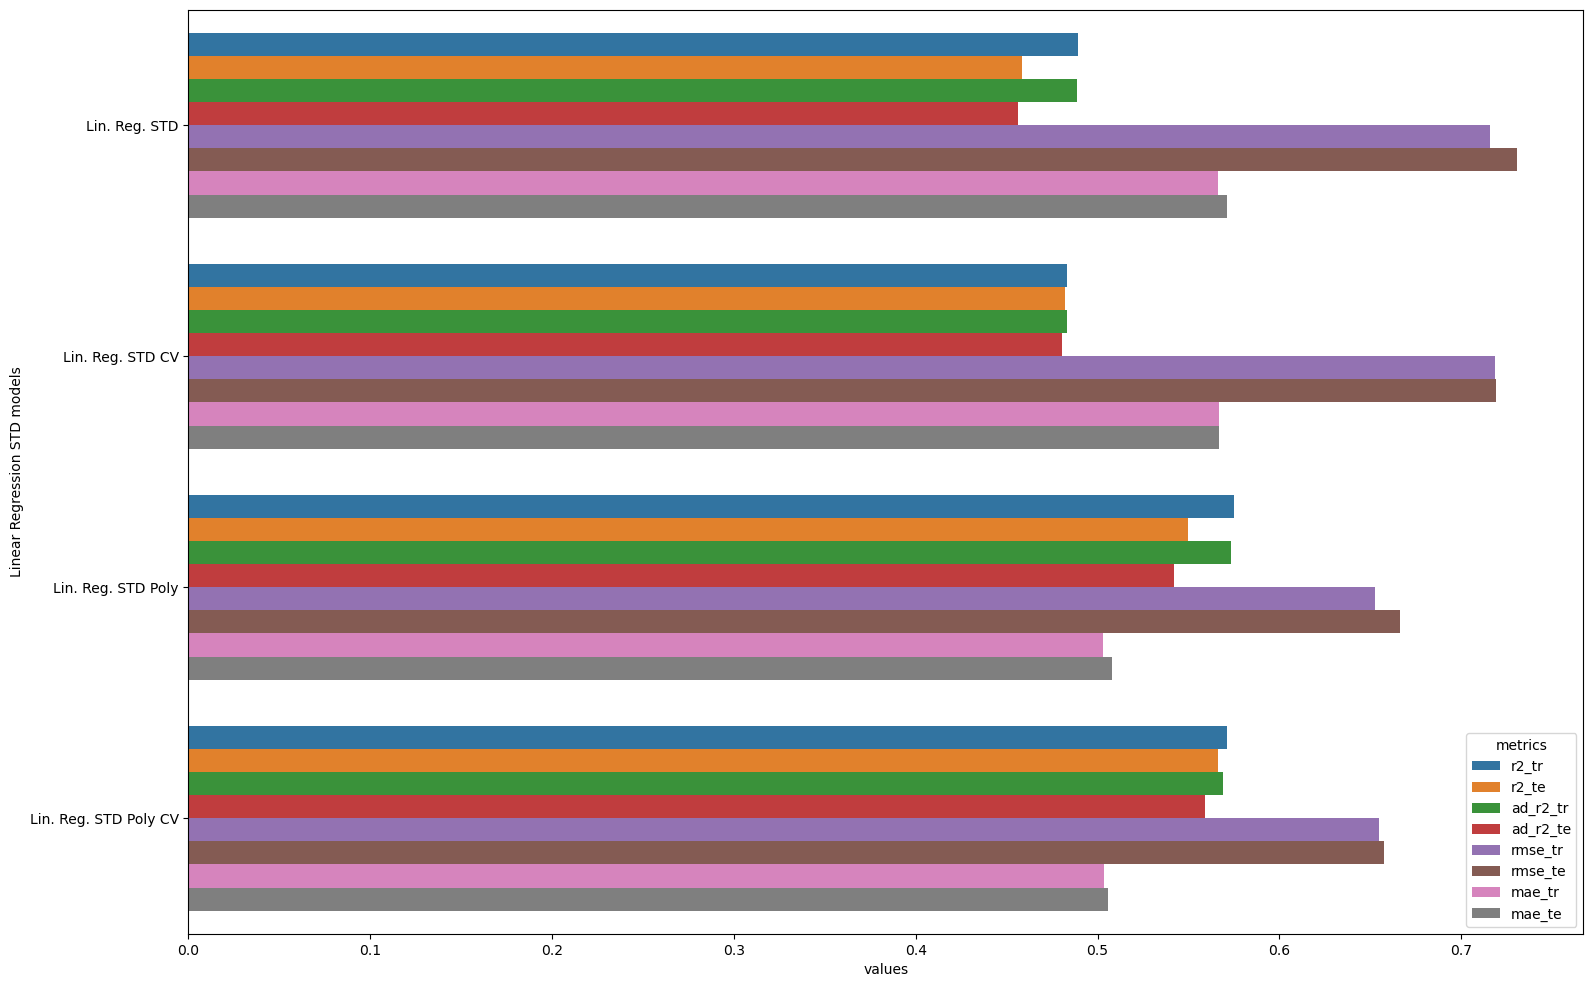

In [55]:
lin_reg_vis([lr_std,lr_std_cv,lr_std_poly,lr_std_poly_cv])

Comparing the r2 and adjusted r2 score for the base and standardized data, it can be deduced that standardization hasn't improved model prediction nor fitting. Moreover, it has actually deteriorated the interpretability of the error metrics. 

The best performing model out of all of them is the linear regression polynomial features model with cross-validation. However, nothing can be inferred from that model in terms of feature importance nor is the score a good result. 

Thus, further analysis has to be conducted with other regressors, such as ElasticNet, Random Forest and Gradient Boost.

# Model training - other regressors

The second trial will encompass 12 models, all of them in base data scale. 

One model will be in its base version, one in base with cross validation, one with polynomial features generation and one with polynomial features generation and cross validation.

Therefore 4 different types of models for 3 regressors. Which gives us exactly 12 models in total.

An overview of the mentioned regressors:

ElasticNet regressor: it is a form of regularized linear regression. 

Regularization is used to reduce overfitting of the model. This is a phenomenon, where the model performs well with the training data, but badly with the test dataset (the dataset the model hasn't seen during the fitting phase).

Elastic Net is used as it combines the regularization of both lasso and ridge, where in the former some features might be totally eliminated, while in the latter, the features are pinalized, but none of them are eliminated, which still has an impact on the model. Elastic Net reduces the impact of different features while not eliminating all of the features.
    
Random Forest regressor: it is a meta estimator that fits a number of classifying decision trees on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.
    
HistGradientBoost regressor: this estimator builds an additive model in a forward stage-wise fashion; it allows for the optimization of arbitrary differentiable loss functions. In each stage a regression tree is fit on the negative gradient of the given loss function. HisGradientBoost is used, since it is a better fit for datasets with samples greater than 10,000.

The following link provides additional information:
1. https://medium.com/@vijay.swamy1/lasso-versus-ridge-versus-elastic-net-1d57cfc64b58
2. https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
3. https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html
4. https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html#sklearn.ensemble.HistGradientBoostingRegressor

In [56]:
# this is a class similar as the one presented above. The only difference is that it was modified for the other regressors.
class regression_models():

    models = {'en':'Elastic Reg.','en_cv':'Elastic Reg. CV','en_poly':'Elastic Reg. Poly.','en_poly_cv':'Elastic Reg. Poly. CV',
              'rf':'Random Forest Reg.','rf_cv':'Random Forest Reg. CV','rf_poly':'Random Forest Reg. Poly.','rf_poly_cv':'Random Forest Reg. Poly. CV',
              'gb':'Gradient Boost Reg.','gb_cv':'Gradient Boost Reg. CV','gb_poly':'Gradient Boost Reg. Poly.','gb_poly_cv':'Gradient Boost Reg. Poly. CV'}
    
    regressors = {'en':elas_net(),'rf':rf_reg(),'gb':gradboost_reg()}
    
    poly = PolynomialFeatures(degree=2, include_bias=False)
    
    kf = KFold()

    def __init__(self, mod_df, title):
        
        self.mod_df = mod_df
        self.title = title
        self.X = self.mod_df.drop(['price'], axis = 1)
        self.y = self.mod_df['price']
        self.metrics_dict = types.SimpleNamespace()
        # to this attribute a DataFrame of the actual and predicted prices will be assigned, to be used with regplot to visualize the regression line and points.
        self.metrics_pd = types.SimpleNamespace()
        self.price_avg = self.y.mean().round(4)
        # to this attribute the fitted regressor will be assigned that will be used for comparison of a model against its hyperparameter tuned version.
        self.model_reg = types.SimpleNamespace()
 
    def ad_r2(self, reg, X, y):
        
        r2 = reg.score(X, y)
        adjusted_r2 = (1 - (1 - r2) * ((X.shape[0] - 1) / (X.shape[0] - X.shape[1] - 1)))
        return adjusted_r2

    def model(self):
        
        X_train_temp, X_test_temp, y_train, y_test = train_test_split(self.X,self.y,test_size=0.2,random_state=42)
        
        if self.title in ['en_poly','rf_poly','gb_poly']:
            pf = self.poly
            X_train, X_test = pf.fit_transform(X_train_temp), pf.fit_transform(X_test_temp)
        else:
            X_train, X_test = X_train_temp, X_test_temp
        
        print(f'\nThe shape of X_train is {X_train.shape} and the shape of X_test is {X_test.shape}\n')
        model_reg = self.regressors.get(self.title[:2],None) 
        reg = model_reg.fit(X_train, y_train)
        self.model_reg = reg
        
        if self.title in ['en','rf']:
            if self.title == 'en':
                imp_pred = pd.DataFrame(np.array([abs(reg.coef_).round(6)]), columns = X_train.columns).sort_values(by = 0, axis = 1, ascending = False).style.hide(axis='index')
            if self.title == 'rf':
                imp_pred = pd.DataFrame(np.array([reg.feature_importances_]), columns = X_train.columns).sort_values(by = 0, axis = 1, ascending = False).style.hide(axis='index')
            display(imp_pred)
        
        param = [self.models.get(self.title)]
        # the following dict and the for loops will be used to produce the actual and predicted prices DataFrame that will be used for regression visualization.
        price_dict = {'actual_price':[],'predicted_price':[]}
        
        for i in y_test: 
            price_dict['actual_price'].append(i)
        
        y_pred_tr = reg.predict(X_train)
        y_pred_te = reg.predict(X_test)
        
        for i in y_pred_te: 
            price_dict['predicted_price'].append(i)
        
        res = {'r2_tr':r2_score(y_train, y_pred_tr).round(4),
               'r2_te':r2_score(y_test, y_pred_te).round(4),
               'ad_r2_tr':self.ad_r2(reg, X_train, y_train).round(4),
               'ad_r2_te':self.ad_r2(reg, X_test, y_test).round(4),
               'rmse_tr':mean_squared_error(y_train, y_pred_tr, squared=False).round(4),
               'rmse_te':mean_squared_error(y_test, y_pred_te, squared=False).round(4),
               'mae_tr':mean_absolute_error(y_train, y_pred_tr).round(4),
               'mae_te':mean_absolute_error(y_test, y_pred_te).round(4),
               'target_variable mean':self.price_avg}
        
        self.metrics_dict = res
        result = pd.DataFrame(self.metrics_dict, index=param)
        self.metrics_pd = pd.DataFrame(price_dict)
        return result
        
    # this method produces the cross validation model metrics and data.
    def model_cv(self):
        
        X, y = self.X, self.y
        res = {'r2_tr':[],'r2_te':[],'ad_r2_tr':[],'ad_r2_te':[],'rmse_tr':[],'rmse_te':[],'mae_tr':[],'mae_te':[]}
        param = [self.models.get(self.title)]
        price_df = pd.DataFrame({'actual_price':[],'predicted_price':[]})
        
        for train, test in self.kf.split(X):
            pred_price = {'actual_price':[],'predicted_price':[]}
            X_train_temp, X_test_temp = X.iloc[train,:], X.iloc[test,:]
            y_train, y_test = y.iloc[train], y.iloc[test]
            
            for i in y_test: 
                pred_price['actual_price'].append(i)
            
            if self.title in ['en_poly_cv','rf_poly_cv','gb_poly_cv']:
                pf = self.poly
                X_train, X_test = pf.fit_transform(X_train_temp), pf.fit_transform(X_test_temp)
            else:
                X_train, X_test = X_train_temp, X_test_temp
            
            print(f'\nThe shape of X_train is {X_train.shape} and the shape of X_test is {X_test.shape}\n')
            model_reg = self.regressors.get(self.title[:2],None)
            reg = model_reg.fit(X_train, y_train)
            
            if self.title in ['en_cv','rf_cv']:
                if self.title == 'en_cv':
                    imp_pred = pd.DataFrame(np.array([abs(reg.coef_).round(6)]), columns = X_train.columns).sort_values(by = 0, axis = 1, ascending = False).style.hide(axis='index')
                if self.title == 'rf_cv':
                    imp_pred = pd.DataFrame(np.array([reg.feature_importances_]), columns = X_train.columns).sort_values(by = 0, axis = 1, ascending = False).style.hide(axis='index')
                display(imp_pred)
            
            y_pred_tr = reg.predict(X_train)
            y_pred_te = reg.predict(X_test)
            
            for i in y_pred_te: 
                pred_price['predicted_price'].append(i)
            
            temp_df = pd.DataFrame(pred_price)
            price_df = pd.concat([price_df,temp_df],ignore_index=True)
            pred_price['actual_price'].append(y_test)
            pred_price['predicted_price'].append(y_pred_te)
            res['r2_tr'].append(r2_score(y_train, y_pred_tr))
            res['r2_te'].append(r2_score(y_test, y_pred_te))
            res['ad_r2_tr'].append(self.ad_r2(reg, X_train, y_train))
            res['ad_r2_te'].append(self.ad_r2(reg, X_test, y_test))
            res['rmse_tr'].append(mean_squared_error(y_train, y_pred_tr, squared=False))
            res['rmse_te'].append(mean_squared_error(y_test, y_pred_te, squared=False))
            res['mae_tr'].append(mean_absolute_error(y_train, y_pred_tr))
            res['mae_te'].append(mean_absolute_error(y_test, y_pred_te))
        
        res = dict(map((lambda item: (item[0], mean(item[1]).round(4))),res.items()))
        res['target_variable mean'] = self.price_avg
        self.metrics_dict = res
        self.metrics_pd = price_df
        result = pd.DataFrame(self.metrics_dict, index=param)
        return result

In [57]:
# the following function displays a DataFrame of the metrics for all the models.
def reg_models_data(models_list):
    
    models_data = {'Regression models':['Elastic Reg.','Elastic Reg. CV','Elastic Reg. Poly.','Elastic Reg. Poly. CV',
                                        'Random Forest Reg.','Random Forest Reg. CV','Random Forest Reg. Poly.','Random Forest Reg. Poly. CV',
                                        'Gradient Boost Reg.','Gradient Boost Reg. CV','Gradient Boost Reg. Poly.','Gradient Boost Reg. Poly. CV'],
                   'r2_tr': [models_list[0].metrics_dict['r2_tr'], models_list[1].metrics_dict['r2_tr'], models_list[2].metrics_dict['r2_tr'], models_list[3].metrics_dict['r2_tr'],
                             models_list[4].metrics_dict['r2_tr'], models_list[5].metrics_dict['r2_tr'], models_list[6].metrics_dict['r2_tr'], models_list[7].metrics_dict['r2_tr'],
                             models_list[8].metrics_dict['r2_tr'], models_list[9].metrics_dict['r2_tr'], models_list[10].metrics_dict['r2_tr'], models_list[11].metrics_dict['r2_tr']],
                   'r2_te': [models_list[0].metrics_dict['r2_te'], models_list[1].metrics_dict['r2_te'], models_list[2].metrics_dict['r2_te'], models_list[3].metrics_dict['r2_te'],
                             models_list[4].metrics_dict['r2_te'], models_list[5].metrics_dict['r2_te'], models_list[6].metrics_dict['r2_te'], models_list[7].metrics_dict['r2_te'],
                             models_list[8].metrics_dict['r2_te'], models_list[9].metrics_dict['r2_te'], models_list[10].metrics_dict['r2_te'], models_list[11].metrics_dict['r2_te']],
                   'ad_r2_tr': [models_list[0].metrics_dict['ad_r2_tr'], models_list[1].metrics_dict['ad_r2_tr'], models_list[2].metrics_dict['ad_r2_tr'], models_list[3].metrics_dict['ad_r2_tr'],
                                models_list[4].metrics_dict['ad_r2_tr'], models_list[5].metrics_dict['ad_r2_tr'], models_list[6].metrics_dict['ad_r2_tr'], models_list[7].metrics_dict['ad_r2_tr'],
                                models_list[8].metrics_dict['ad_r2_tr'], models_list[9].metrics_dict['ad_r2_tr'], models_list[10].metrics_dict['ad_r2_tr'], models_list[11].metrics_dict['ad_r2_tr']],
                   'ad_r2_te': [models_list[0].metrics_dict['ad_r2_te'], models_list[1].metrics_dict['ad_r2_te'], models_list[2].metrics_dict['ad_r2_te'], models_list[3].metrics_dict['ad_r2_te'],
                                models_list[4].metrics_dict['ad_r2_te'], models_list[5].metrics_dict['ad_r2_te'], models_list[6].metrics_dict['ad_r2_te'], models_list[7].metrics_dict['ad_r2_te'],
                                models_list[8].metrics_dict['ad_r2_te'], models_list[9].metrics_dict['ad_r2_te'], models_list[10].metrics_dict['ad_r2_te'], models_list[11].metrics_dict['ad_r2_te']],
                   'rmse_tr': [models_list[0].metrics_dict['rmse_tr'], models_list[1].metrics_dict['rmse_tr'], models_list[2].metrics_dict['rmse_tr'], models_list[3].metrics_dict['rmse_tr'],
                               models_list[4].metrics_dict['rmse_tr'], models_list[5].metrics_dict['rmse_tr'], models_list[6].metrics_dict['rmse_tr'], models_list[7].metrics_dict['rmse_tr'],
                               models_list[8].metrics_dict['rmse_tr'], models_list[9].metrics_dict['rmse_tr'], models_list[10].metrics_dict['rmse_tr'], models_list[11].metrics_dict['rmse_tr']],
                   'rmse_te': [models_list[0].metrics_dict['rmse_te'], models_list[1].metrics_dict['rmse_te'], models_list[2].metrics_dict['rmse_te'], models_list[3].metrics_dict['rmse_te'],
                               models_list[4].metrics_dict['rmse_te'], models_list[5].metrics_dict['rmse_te'], models_list[6].metrics_dict['rmse_te'], models_list[7].metrics_dict['rmse_te'],
                               models_list[8].metrics_dict['rmse_te'], models_list[9].metrics_dict['rmse_te'], models_list[10].metrics_dict['rmse_te'], models_list[11].metrics_dict['rmse_te']],
                   'mae_tr': [models_list[0].metrics_dict['mae_tr'], models_list[1].metrics_dict['mae_tr'], models_list[2].metrics_dict['mae_tr'], models_list[3].metrics_dict['mae_tr'],
                              models_list[4].metrics_dict['mae_tr'], models_list[5].metrics_dict['mae_tr'], models_list[6].metrics_dict['mae_tr'], models_list[7].metrics_dict['mae_tr'],
                              models_list[8].metrics_dict['mae_tr'], models_list[9].metrics_dict['mae_tr'], models_list[10].metrics_dict['mae_tr'], models_list[11].metrics_dict['mae_tr']],
                   'mae_te': [models_list[0].metrics_dict['mae_te'], models_list[1].metrics_dict['mae_te'], models_list[2].metrics_dict['mae_te'], models_list[3].metrics_dict['mae_te'],
                              models_list[4].metrics_dict['mae_te'], models_list[5].metrics_dict['mae_te'], models_list[6].metrics_dict['mae_te'], models_list[7].metrics_dict['mae_te'],
                              models_list[8].metrics_dict['mae_te'], models_list[9].metrics_dict['mae_te'], models_list[10].metrics_dict['mae_te'], models_list[11].metrics_dict['mae_te']]}
    
    models_df = pd.DataFrame(data=models_data)
    models_df_sty = models_df.style.hide(axis='index')
    return models_df_sty

The codes below will initialize the class and compute the metrics. These will be described at the end.

In [58]:
en = regression_models(mod_df, 'en')

en.model()


The shape of X_train is (8209, 7) and the shape of X_test is (2053, 7)



r2_tr   r2_te  ad_r2_tr  ad_r2_te    rmse_tr    rmse_te  \
Elastic Reg.  0.4084  0.3979    0.4079    0.3959  3120.9192  3121.3819   

                 mae_tr     mae_te  target_variable mean  
Elastic Reg.  2488.2715  2449.4997             8788.4998

In [59]:
en_cv = regression_models(mod_df, 'en_cv')

en_cv.model_cv()


The shape of X_train is (8209, 7) and the shape of X_test is (2053, 7)




The shape of X_train is (8209, 7) and the shape of X_test is (2053, 7)




The shape of X_train is (8210, 7) and the shape of X_test is (2052, 7)




The shape of X_train is (8210, 7) and the shape of X_test is (2052, 7)




The shape of X_train is (8210, 7) and the shape of X_test is (2052, 7)



r2_tr   r2_te  ad_r2_tr  ad_r2_te    rmse_tr    rmse_te  \
Elastic Reg. CV  0.4053  0.4039    0.4048    0.4018  3124.0848  3125.8391   

                   mae_tr     mae_te  target_variable mean  
Elastic Reg. CV  2480.107  2481.2679             8788.4998

In [60]:
en_poly = regression_models(mod_df, 'en_poly')

en_poly.model()


The shape of X_train is (8209, 35) and the shape of X_test is (2053, 35)



r2_tr   r2_te  ad_r2_tr  ad_r2_te    rmse_tr    rmse_te  \
Elastic Reg. Poly.  0.5656  0.5384    0.5637    0.5304  2674.5235  2732.9752   

                       mae_tr     mae_te  target_variable mean  
Elastic Reg. Poly.  2055.4599  2079.7573             8788.4998

In [61]:
en_poly_cv = regression_models(mod_df, 'en_poly_cv')

en_poly_cv.model_cv()


The shape of X_train is (8209, 35) and the shape of X_test is (2053, 35)


The shape of X_train is (8209, 35) and the shape of X_test is (2053, 35)


The shape of X_train is (8210, 35) and the shape of X_test is (2052, 35)


The shape of X_train is (8210, 35) and the shape of X_test is (2052, 35)


The shape of X_train is (8210, 35) and the shape of X_test is (2052, 35)



r2_tr   r2_te  ad_r2_tr  ad_r2_te    rmse_tr  \
Elastic Reg. Poly. CV  0.5606  0.5581    0.5588    0.5505  2685.2948   

                         rmse_te     mae_tr     mae_te  target_variable mean  
Elastic Reg. Poly. CV  2690.7153  2056.9358  2061.0836             8788.4998

In [62]:
rf = regression_models(mod_df, 'rf')

rf.model()


The shape of X_train is (8209, 7) and the shape of X_test is (2053, 7)



r2_tr   r2_te  ad_r2_tr  ad_r2_te    rmse_tr    rmse_te  \
Random Forest Reg.  0.8589  0.7608    0.8588    0.7599  1524.0205  1967.6342   

                      mae_tr     mae_te  target_variable mean  
Random Forest Reg.  965.9935  1242.8939             8788.4998

In [63]:
rf_cv = regression_models(mod_df, 'rf_cv')

rf_cv.model_cv()


The shape of X_train is (8209, 7) and the shape of X_test is (2053, 7)




The shape of X_train is (8209, 7) and the shape of X_test is (2053, 7)




The shape of X_train is (8210, 7) and the shape of X_test is (2052, 7)




The shape of X_train is (8210, 7) and the shape of X_test is (2052, 7)




The shape of X_train is (8210, 7) and the shape of X_test is (2052, 7)



r2_tr   r2_te  ad_r2_tr  ad_r2_te    rmse_tr  \
Random Forest Reg. CV  0.8573  0.7692    0.8571    0.7684  1530.5409   

                         rmse_te    mae_tr     mae_te  target_variable mean  
Random Forest Reg. CV  1944.8963  965.9901  1237.0904             8788.4998

In [64]:
rf_poly = regression_models(mod_df, 'rf_poly')

rf_poly.model()


The shape of X_train is (8209, 35) and the shape of X_test is (2053, 35)



r2_tr   r2_te  ad_r2_tr  ad_r2_te    rmse_tr  \
Random Forest Reg. Poly.  0.8588  0.7612    0.8582    0.7571  1524.4904   

                            rmse_te    mae_tr     mae_te  target_variable mean  
Random Forest Reg. Poly.  1965.6491  966.1916  1247.0553             8788.4998

In [65]:
rf_poly_cv = regression_models(mod_df, 'rf_poly_cv')

rf_poly_cv.model_cv()


The shape of X_train is (8209, 35) and the shape of X_test is (2053, 35)


The shape of X_train is (8209, 35) and the shape of X_test is (2053, 35)


The shape of X_train is (8210, 35) and the shape of X_test is (2052, 35)


The shape of X_train is (8210, 35) and the shape of X_test is (2052, 35)


The shape of X_train is (8210, 35) and the shape of X_test is (2052, 35)



r2_tr   r2_te  ad_r2_tr  ad_r2_te    rmse_tr  \
Random Forest Reg. Poly. CV  0.8572  0.7694    0.8566    0.7654  1530.7628   

                               rmse_te    mae_tr     mae_te  \
Random Forest Reg. Poly. CV  1943.9993  966.6778  1239.6558   

                             target_variable mean  
Random Forest Reg. Poly. CV             8788.4998

In [66]:
gb = regression_models(mod_df, 'gb')

gb.model()


The shape of X_train is (8209, 7) and the shape of X_test is (2053, 7)



r2_tr   r2_te  ad_r2_tr  ad_r2_te    rmse_tr    rmse_te  \
Gradient Boost Reg.  0.7936  0.7515    0.7934    0.7507  1843.3708  2005.2322   

                        mae_tr     mae_te  target_variable mean  
Gradient Boost Reg.  1247.9418  1331.6629             8788.4998

In [67]:
gb_cv = regression_models(mod_df, 'gb_cv')

gb_cv.model_cv()


The shape of X_train is (8209, 7) and the shape of X_test is (2053, 7)


The shape of X_train is (8209, 7) and the shape of X_test is (2053, 7)


The shape of X_train is (8210, 7) and the shape of X_test is (2052, 7)


The shape of X_train is (8210, 7) and the shape of X_test is (2052, 7)


The shape of X_train is (8210, 7) and the shape of X_test is (2052, 7)



r2_tr  r2_te  ad_r2_tr  ad_r2_te    rmse_tr  \
Gradient Boost Reg. CV  0.791  0.765    0.7908    0.7642  1852.1166   

                          rmse_te     mae_tr     mae_te  target_variable mean  
Gradient Boost Reg. CV  1962.6301  1249.2221  1323.1759             8788.4998

In [68]:
gb_poly = regression_models(mod_df, 'gb_poly')

gb_poly.model()


The shape of X_train is (8209, 35) and the shape of X_test is (2053, 35)



r2_tr   r2_te  ad_r2_tr  ad_r2_te    rmse_tr  \
Gradient Boost Reg. Poly.  0.8133  0.7639    0.8125    0.7598  1753.4408   

                             rmse_te     mae_tr     mae_te  \
Gradient Boost Reg. Poly.  1954.5696  1178.9035  1280.8799   

                           target_variable mean  
Gradient Boost Reg. Poly.             8788.4998

In [69]:
gb_poly_cv = regression_models(mod_df, 'gb_poly_cv')

gb_poly_cv.model_cv()


The shape of X_train is (8209, 35) and the shape of X_test is (2053, 35)


The shape of X_train is (8209, 35) and the shape of X_test is (2053, 35)


The shape of X_train is (8210, 35) and the shape of X_test is (2052, 35)


The shape of X_train is (8210, 35) and the shape of X_test is (2052, 35)


The shape of X_train is (8210, 35) and the shape of X_test is (2052, 35)



r2_tr   r2_te  ad_r2_tr  ad_r2_te    rmse_tr  \
Gradient Boost Reg. Poly. CV   0.81  0.7743    0.8092    0.7704  1765.9365   

                                rmse_te     mae_tr     mae_te  \
Gradient Boost Reg. Poly. CV  1923.4939  1185.0005  1287.4715   

                              target_variable mean  
Gradient Boost Reg. Poly. CV             8788.4998

In [70]:
reg_models_data([en,en_cv,en_poly,en_poly_cv,rf,rf_cv,rf_poly,rf_poly_cv,gb,gb_cv,gb_poly,gb_poly_cv])

The two best performing models are Random Forest and Gradient Boost regressor. The cross validation version nor polynomial features won't be used for hyperparameter tuning, since the base and poly of these regressors carry similar scores, whereas the base provide better interpretability of features importance in price formulation.

The two were selected as not only their values are the highest in comparison to Linear Regression and ElasticNet, but they are quite close between train and test. Thus, the models weren't overfitted and can be used for hyperparameter tuning to produce even better results.

But, before taking the final decision of which models should be passed to the hyperparameter tuning function, the following visualizations will be used to look at the regression plot of the predicted and actual values of the target variable, as well as, a residual plots to describe by how off have the model been from the actual values.

In terms of the residual plot, the positive values for the residual (on the y-axis) mean the prediction was too low, and negative values mean the prediction was too high; 0 means the guess was exactly correct.

Link to information about residual interpretability: https://www.qualtrics.com/support/stats-iq/analyses/regression-guides/interpreting-residual-plots-improve-regression/

<Figure size 1000x500 with 0 Axes>

<AxesSubplot:xlabel='actual_price', ylabel='predicted_price'>

Text(0.5, 1.0, 'Actual Price  Vs  Predicted Price - RF')

Text(0.5, 0, 'Actual Price')

Text(0, 0.5, 'Predicted Price')

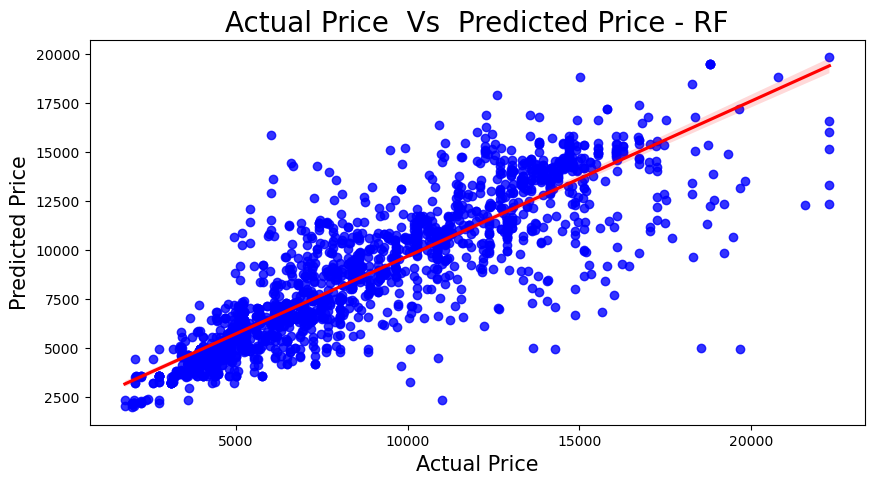

In [75]:
plt.figure(figsize=(10,5))
sns.regplot(x='actual_price',y='predicted_price',data=rf.metrics_pd,scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})
plt.title('Actual Price  Vs  Predicted Price - RF',fontsize=20)
plt.xlabel('Actual Price',fontsize=15)
plt.ylabel('Predicted Price',fontsize=15)
plt.show()

<Figure size 1000x500 with 0 Axes>

<AxesSubplot:xlabel='actual_price', ylabel='predicted_price'>

Text(0.5, 1.0, 'Actual Price  Vs  Predicted Price - GB')

Text(0.5, 0, 'Actual Price')

Text(0, 0.5, 'Predicted Price')

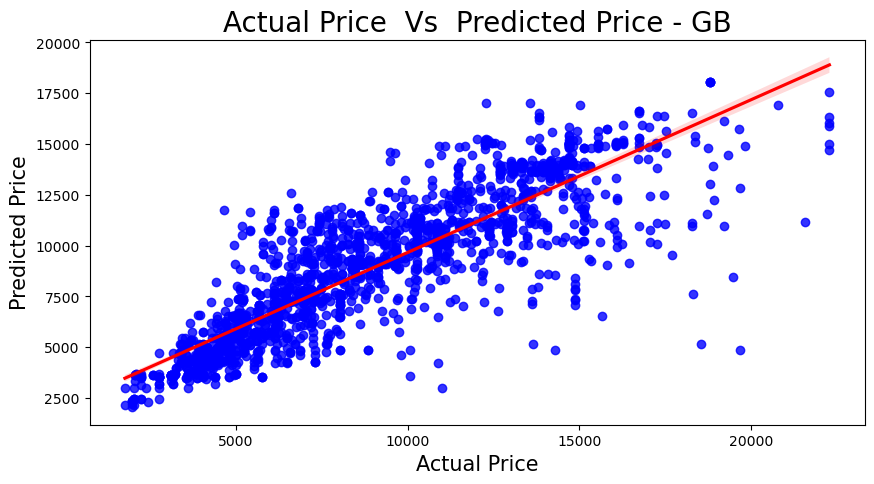

In [76]:
plt.figure(figsize=(10,5))
sns.regplot(x='actual_price',y='predicted_price',data=gb.metrics_pd,scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})
plt.title('Actual Price  Vs  Predicted Price - GB',fontsize=20)
plt.xlabel('Actual Price',fontsize=15)
plt.ylabel('Predicted Price',fontsize=15)
plt.show()

<Figure size 1000x500 with 0 Axes>

<AxesSubplot:xlabel='actual_price', ylabel='predicted_price'>

Text(0.5, 1.0, 'Actual Price  Vs  Predicted Price - RF')

Text(0.5, 0, 'Actual Price')

Text(0, 0.5, 'Predicted Price')

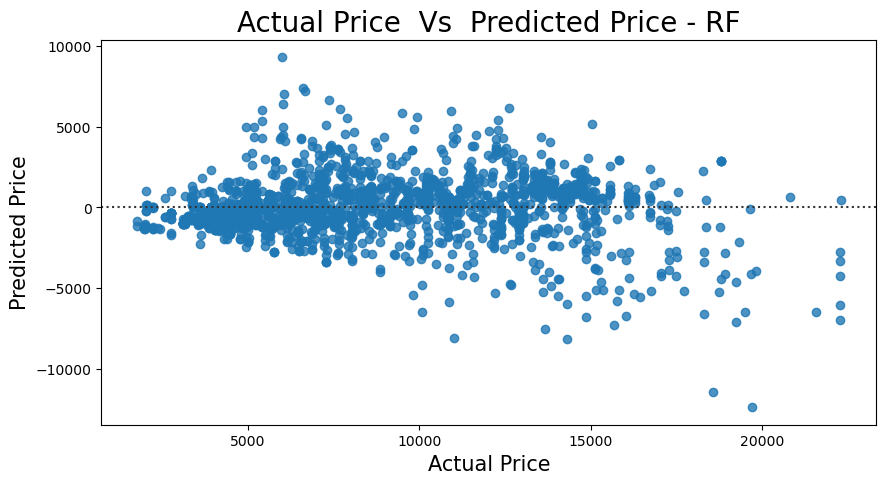

In [77]:
plt.figure(figsize=(10,5))
sns.residplot(data=rf.metrics_pd,x='actual_price',y='predicted_price')
plt.title('Actual Price  Vs  Predicted Price - RF',fontsize=20)
plt.xlabel('Actual Price',fontsize=15)
plt.ylabel('Predicted Price',fontsize=15)
plt.show()

<Figure size 1000x500 with 0 Axes>

<AxesSubplot:xlabel='actual_price', ylabel='predicted_price'>

Text(0.5, 1.0, 'Actual Price  Vs  Predicted Price - GB')

Text(0.5, 0, 'Actual Price')

Text(0, 0.5, 'Predicted Price')

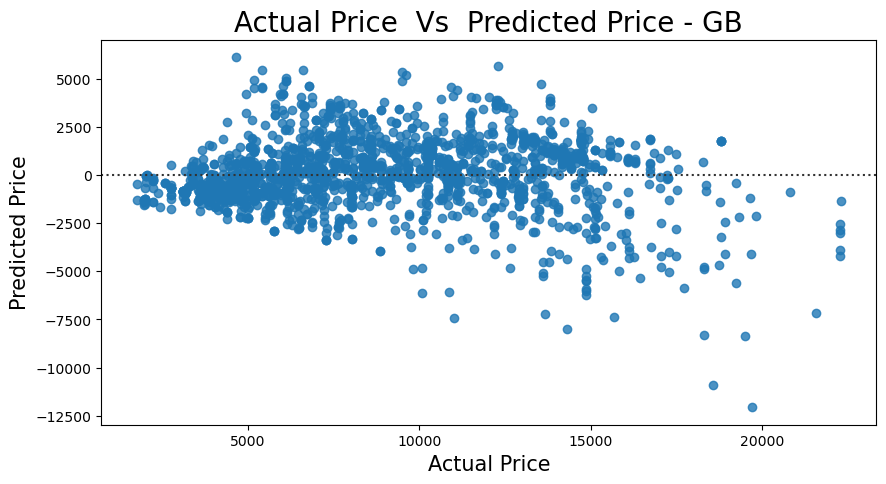

In [78]:
plt.figure(figsize=(10,5))
sns.residplot(data=gb.metrics_pd,x='actual_price',y='predicted_price')
plt.title('Actual Price  Vs  Predicted Price - GB',fontsize=20)
plt.xlabel('Actual Price',fontsize=15)
plt.ylabel('Predicted Price',fontsize=15)
plt.show()

From the two plots, it can be deduced that Gradient boost has performed a little better than Random forest, since the values are concentrated around the line and according to the residuals, the values were only slightly off in comparison to Random Forest. 

Nevertheless, both of them will be passed for hyperparameter tuning.

In terms of the selected parameters for each of the above-mentioned regressor, below are details related to them:

For Random Forest:

n_estimators - the number of Decision Trees.

max_features - the maximum number of features (categories) that are taken into consideration at every split-level. The selected features are at random. If square root is passed, then max_features = sqrt(n_features). Similarly, max_features with log2 = log2(n_features).  

max_depth - max depth of the tree. Till what point are the nodes expanded. If None, it will expand till all leaves are pure or if the leaves contain less than min_samples_split.

min_samples_split - he minimum number of samples required to split an internal node.

min_samples_leaf - The minimum number of samples required to be at a leaf node.

For Gradient Boost:

learning_rate - the learning rate, also known as shrinkage. This is used as a multiplicative factor for the leaves values.

max_iter - the maximum number of iterations of the boosting process, i.e. the maximum number of trees.

max_depth - the maximum depth of each tree. The depth of a tree is the number of edges to go from the root to the deepest leaf.

Links to information about hyperparameter tuning of Random Forest and Gradient Boost:
1. https://www.analyticsvidhya.com/blog/2020/03/beginners-guide-random-forest-hyperparameter-tuning/
2. https://stackoverflow.com/questions/43590489/gridsearchcv-random-forest-regressor-tuning-best-params
3. https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html 
4. https://towardsdatascience.com/xgboost-fine-tune-and-optimize-your-model-23d996fab663

# Hyperparameter Tuning

In [86]:
# these functions encompass the whole hyperparameter procedure.
# at first, the regressor is tuned, then a cross validation is conducted to see what is its best values.
# at the end, a DataFrame will be returned of predicted and actual values that will be plotted on the regreesion and residual graphs.
def best_estimator_check(passphrase):
    
    X, y = mod_df.drop(['price'], axis = 1), mod_df['price']
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
    
    if passphrase == 'grd_rf':
        regressor = rf_reg()
        src_space = {'n_estimators':[100,200,500],'max_depth':[4,6,8],'min_samples_split':[3,5],'min_samples_leaf':[3,5],'max_features':['sqrt','log2']}
    else:
        regressor = gradboost_reg()
        src_space = {'learning_rate':[0.01,0.05,0.1],'max_iter':[500],'max_depth':[4,6,8]}
        
    grd_src = GridSearchCV(regressor,src_space,cv=5,scoring=['r2','neg_root_mean_squared_error','neg_mean_absolute_error'],refit='r2')
    model = grd_src.fit(X_train, y_train)
    
    return model


def best_estimator_cross_val(best_estimator,passphrase):

    X, y = mod_df.drop(['price'], axis = 1), mod_df['price']
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
    
    regressor = best_estimator    
    res = cross_val_score(regressor, X_train, y_train, cv=5)
    
    if passphrase == 'grd_rf':
        print(f'''The score of Random Forest Tuned Regressor CV is: {res.round(4)},\nThe mean of Random Forest Tuned Regressor CV is: {res.mean().round(4)},\nThe standard deviation of Random Forest Tuned Regressor CV is: {res.std().round(4)}''')
    else:
        print(f'''The score of Gradient Boost Tuned Regressor CV is: {res.round(4)},\nThe mean of Gradient Boost Tuned Regressor CV is: {res.mean().round(4)},\nThe standard deviation of Gradient Boost Tuned Regressor CV is: {res.std().round(4)}''')
    
    return 


def ad_r2(reg, X, y):
    
    r2 = reg.score(X, y)
    adjusted_r2 = (1 - (1 - r2) * ((X.shape[0] - 1) / (X.shape[0] - X.shape[1] - 1)))
    
    return adjusted_r2


def final_models(estimator,passphrase):
    
    X, y = mod_df.drop(['price'], axis = 1), mod_df['price']
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
    reg = estimator
    
    if passphrase == 'grd_rf':
        param = ['Tuned Random Forest']
    else:
        param = ['Tuned Gradient Boost']
    
    price_dict = {'actual_price':[],'predicted_price':[]}
    
    for i in y_test: 
        price_dict['actual_price'].append(i)
        
    y_pred_tr = reg.predict(X_train)
    y_pred_te = reg.predict(X_test)
    
    for i in y_pred_te: 
        price_dict['predicted_price'].append(i)
        
    res = {'r2_tr':r2_score(y_train, y_pred_tr).round(4),
           'r2_te':r2_score(y_test, y_pred_te).round(4),
           'ad_r2_tr':ad_r2(reg, X_train, y_train).round(4),
           'ad_r2_te':ad_r2(reg, X_test, y_test).round(4),
           'rmse_tr':mean_squared_error(y_train, y_pred_tr, squared=False).round(4),
           'rmse_te':mean_squared_error(y_test, y_pred_te, squared=False).round(4),
           'mae_tr':mean_absolute_error(y_train, y_pred_tr).round(4),
           'mae_te':mean_absolute_error(y_test, y_pred_te).round(4),
           'target_variable mean':y.mean().round(4)}
    
    result = pd.DataFrame(res, index=param)
    
    if passphrase == 'grd_rf':
        imp_pred = pd.DataFrame(np.array([estimator.feature_importances_]), columns = X_train.columns).sort_values(by = 0, axis = 1, ascending = False).style.hide(axis='index')
        display(imp_pred)
        
    display(result)
    metrics_pd = pd.DataFrame(price_dict)
    return metrics_pd

In [80]:
rf_est_check = best_estimator_check('grd_rf')

rf_est_check.best_estimator_

print(f'Random Forest Hyperparameter Tuning best result is: {rf_est_check.best_score_.round(4)}')

RandomForestRegressor(max_depth=8, max_features='sqrt', min_samples_leaf=3,
                      min_samples_split=5, n_estimators=500)

Random Forest Hyperparameter Tuning best result is: 0.734


In [81]:
gb_est_check = best_estimator_check('grd_gb')

gb_est_check.best_estimator_

print(f'Gradient Boost Hyperparameter Tuning best result is: {gb_est_check.best_score_.round(4)}')

HistGradientBoostingRegressor(max_depth=8, max_iter=500)

Gradient Boost Hyperparameter Tuning best result is: 0.7708


In [82]:
rf_est_cv_results = best_estimator_cross_val(rf_est_check.best_estimator_,'grd_rf')

rf_est_cv_results

The score of Random Forest Tuned Regressor CV is: [0.7155 0.7539 0.7457 0.7196 0.7311],
The mean of Random Forest Tuned Regressor CV is: 0.7331,
The standard deviation of Random Forest Tuned Regressor CV is: 0.0147


In [83]:
gb_est_check_results = best_estimator_cross_val(gb_est_check.best_estimator_,'grd_gb')

gb_est_check_results

The score of Gradient Boost Tuned Regressor CV is: [0.7607 0.7824 0.783  0.7563 0.7713],
The mean of Gradient Boost Tuned Regressor CV is: 0.7708,
The standard deviation of Gradient Boost Tuned Regressor CV is: 0.0109


In [84]:
print('\nTuned Random Forest results')
tuned_rf = final_models(rf_est_check.best_estimator_,'grd_rf')

print('\nBase Random Forest results\n')
rf.model()


Tuned Random Forest results


r2_tr   r2_te  ad_r2_tr  ad_r2_te    rmse_tr    rmse_te  \
Tuned Random Forest  0.7489  0.7167    0.7487    0.7157  2033.2567  2141.1074   

                        mae_tr     mae_te  target_variable mean  
Tuned Random Forest  1455.9776  1489.4104             8788.4998


Base Random Forest results


The shape of X_train is (8209, 7) and the shape of X_test is (2053, 7)



r2_tr   r2_te  ad_r2_tr  ad_r2_te    rmse_tr    rmse_te  \
Random Forest Reg.  0.8588  0.7605    0.8587    0.7597  1524.9006  1968.4673   

                      mae_tr     mae_te  target_variable mean  
Random Forest Reg.  964.9257  1240.4679             8788.4998

In [87]:
print('\nTuned Gradient Boost results')
tuned_gb = final_models(gb_est_check.best_estimator_,'grd_gb')

print('\nBase Gradient Boost results\n')
gb.model()


Tuned Gradient Boost results


r2_tr  r2_te  ad_r2_tr  ad_r2_te    rmse_tr    rmse_te  \
Tuned Gradient Boost  0.8236  0.763    0.8235    0.7622  1704.0419  1958.2238   

                        mae_tr     mae_te  target_variable mean  
Tuned Gradient Boost  1136.918  1282.3311             8788.4998


Base Gradient Boost results


The shape of X_train is (8209, 7) and the shape of X_test is (2053, 7)



r2_tr   r2_te  ad_r2_tr  ad_r2_te    rmse_tr    rmse_te  \
Gradient Boost Reg.  0.7936  0.7515    0.7934    0.7507  1843.3708  2005.2322   

                        mae_tr     mae_te  target_variable mean  
Gradient Boost Reg.  1247.9418  1331.6629             8788.4998

From the above results it can be clearly noticed that the Tuned Gradient Boost has not only the best test scores, but it also doesn't exhibit overfitting, since the test and train results aren't that far apart.

But before deciding which model could be used for price prediction, the regression and residual plots will be applied again to see the concentration of data, regression line and also the by how far off are the predictions from actual data on the residual plot.

<Figure size 1000x500 with 0 Axes>

<AxesSubplot:xlabel='actual_price', ylabel='predicted_price'>

Text(0.5, 1.0, 'Actual Price  Vs  Predicted Price - Tuned RF')

Text(0.5, 0, 'Actual Price')

Text(0, 0.5, 'Predicted Price')

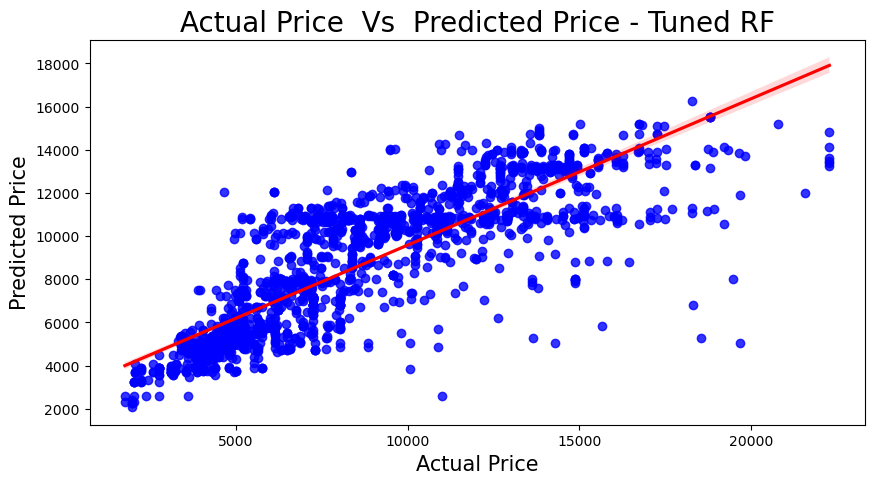

<Figure size 1000x500 with 0 Axes>

<AxesSubplot:xlabel='actual_price', ylabel='predicted_price'>

Text(0.5, 1.0, 'Actual Price  Vs  Predicted Price - Base RF')

Text(0.5, 0, 'Actual Price')

Text(0, 0.5, 'Predicted Price')

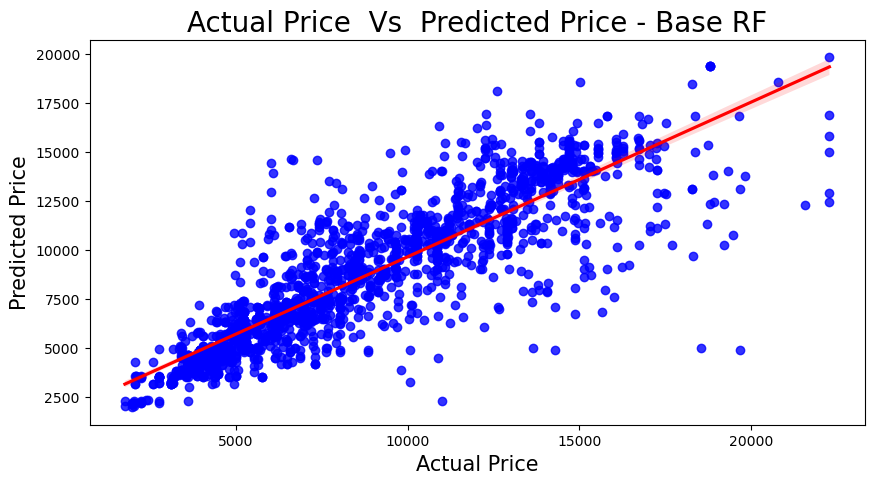

In [88]:
plt.figure(figsize=(10,5))
sns.regplot(x='actual_price',y='predicted_price',data=tuned_rf,scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})
plt.title('Actual Price  Vs  Predicted Price - Tuned RF',fontsize=20)
plt.xlabel('Actual Price',fontsize=15)
plt.ylabel('Predicted Price',fontsize=15)
plt.show()

plt.figure(figsize=(10,5))
sns.regplot(x='actual_price',y='predicted_price',data=rf.metrics_pd,scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})
plt.title('Actual Price  Vs  Predicted Price - Base RF',fontsize=20)
plt.xlabel('Actual Price',fontsize=15)
plt.ylabel('Predicted Price',fontsize=15)
plt.show()

<Figure size 1000x500 with 0 Axes>

<AxesSubplot:xlabel='actual_price', ylabel='predicted_price'>

Text(0.5, 1.0, 'Actual Price  Vs  Predicted Price - Tuned GB')

Text(0.5, 0, 'Actual Price')

Text(0, 0.5, 'Predicted Price')

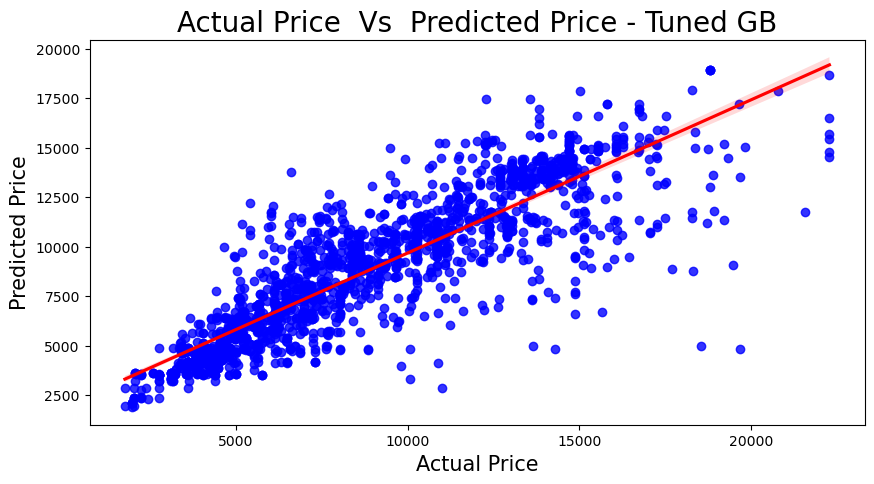

<Figure size 1000x500 with 0 Axes>

<AxesSubplot:xlabel='actual_price', ylabel='predicted_price'>

Text(0.5, 1.0, 'Actual Price  Vs  Predicted Price - Base GB')

Text(0.5, 0, 'Actual Price')

Text(0, 0.5, 'Predicted Price')

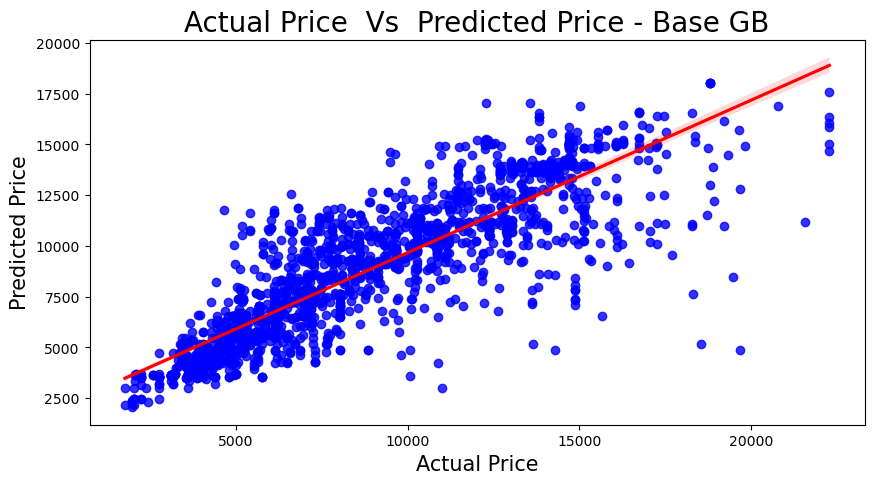

In [89]:
plt.figure(figsize=(10,5))
sns.regplot(x='actual_price',y='predicted_price',data=tuned_gb,scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})
plt.title('Actual Price  Vs  Predicted Price - Tuned GB',fontsize=20)
plt.xlabel('Actual Price',fontsize=15)
plt.ylabel('Predicted Price',fontsize=15)
plt.show()

plt.figure(figsize=(10,5))
sns.regplot(x='actual_price',y='predicted_price',data=gb.metrics_pd,scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})
plt.title('Actual Price  Vs  Predicted Price - Base GB',fontsize=20)
plt.xlabel('Actual Price',fontsize=15)
plt.ylabel('Predicted Price',fontsize=15)
plt.show()

<Figure size 1000x500 with 0 Axes>

<AxesSubplot:xlabel='actual_price', ylabel='predicted_price'>

Text(0.5, 1.0, 'Actual Price  Vs  Predicted Price - Tuned RF')

Text(0.5, 0, 'Actual Price')

Text(0, 0.5, 'Predicted Price')

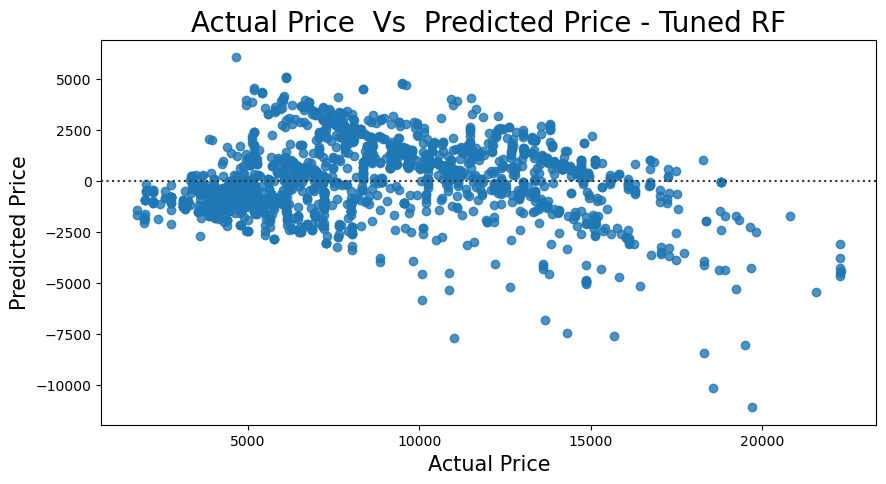

<Figure size 1000x500 with 0 Axes>

<AxesSubplot:xlabel='actual_price', ylabel='predicted_price'>

Text(0.5, 1.0, 'Actual Price  Vs  Predicted Price - Base RF')

Text(0.5, 0, 'Actual Price')

Text(0, 0.5, 'Predicted Price')

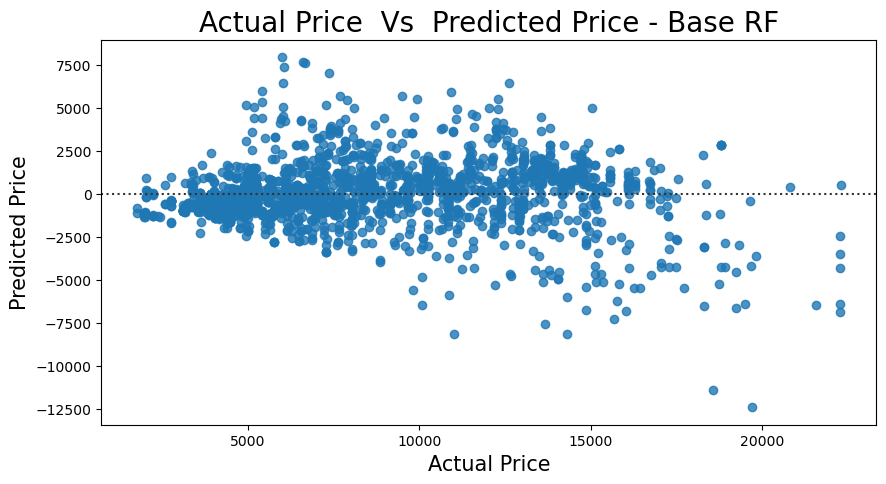

In [90]:
plt.figure(figsize=(10,5))
sns.residplot(data=tuned_rf,x='actual_price',y='predicted_price')
plt.title('Actual Price  Vs  Predicted Price - Tuned RF',fontsize=20)
plt.xlabel('Actual Price',fontsize=15)
plt.ylabel('Predicted Price',fontsize=15)
plt.show()

plt.figure(figsize=(10,5))
sns.residplot(data=rf.metrics_pd,x='actual_price',y='predicted_price')
plt.title('Actual Price  Vs  Predicted Price - Base RF',fontsize=20)
plt.xlabel('Actual Price',fontsize=15)
plt.ylabel('Predicted Price',fontsize=15)
plt.show()

<Figure size 1000x500 with 0 Axes>

<AxesSubplot:xlabel='actual_price', ylabel='predicted_price'>

Text(0.5, 1.0, 'Actual Price  Vs  Predicted Price - Tuned GB')

Text(0.5, 0, 'Actual Price')

Text(0, 0.5, 'Predicted Price')

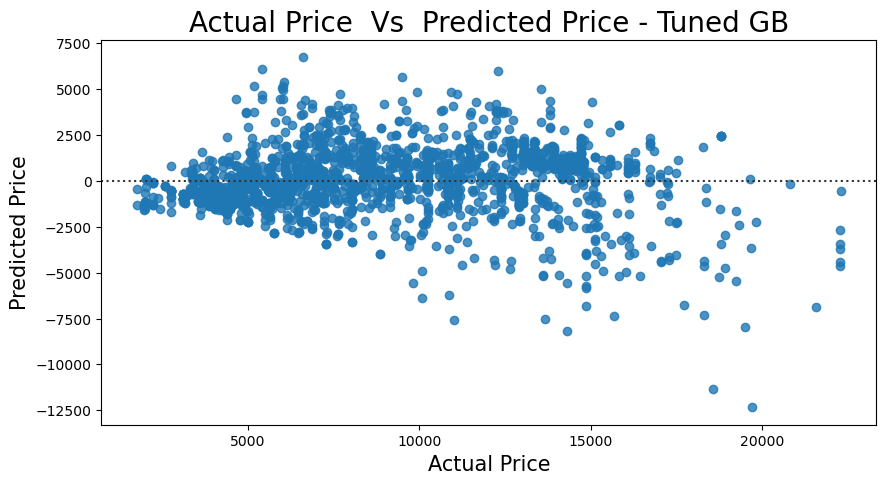

<Figure size 1000x500 with 0 Axes>

<AxesSubplot:xlabel='actual_price', ylabel='predicted_price'>

Text(0.5, 1.0, 'Actual Price  Vs  Predicted Price - Base GB')

Text(0.5, 0, 'Actual Price')

Text(0, 0.5, 'Predicted Price')

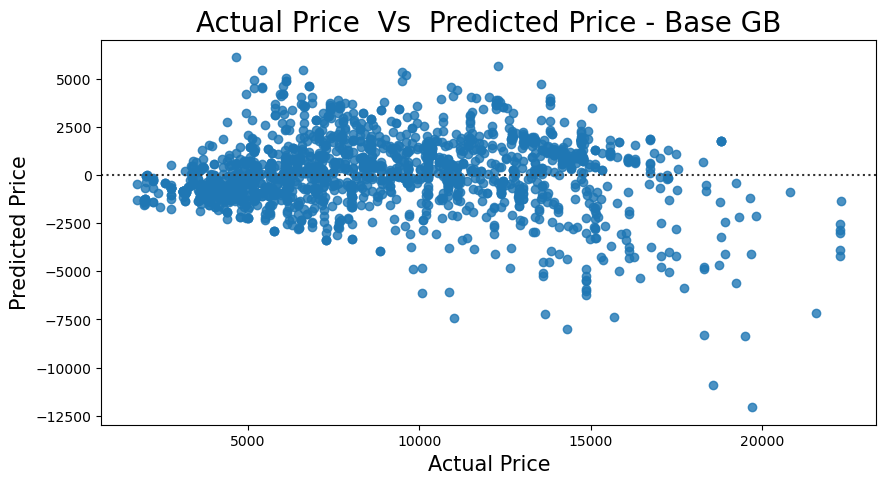

In [91]:
plt.figure(figsize=(10,5))
sns.residplot(data=tuned_gb,x='actual_price',y='predicted_price')
plt.title('Actual Price  Vs  Predicted Price - Tuned GB',fontsize=20)
plt.xlabel('Actual Price',fontsize=15)
plt.ylabel('Predicted Price',fontsize=15)
plt.show()

plt.figure(figsize=(10,5))
sns.residplot(data=gb.metrics_pd,x='actual_price',y='predicted_price')
plt.title('Actual Price  Vs  Predicted Price - Base GB',fontsize=20)
plt.xlabel('Actual Price',fontsize=15)
plt.ylabel('Predicted Price',fontsize=15)
plt.show()

All the models seem to perform quite similarly. However, considering the scores presented in the above DataFrame and the sparsity of values in residuals as well as on the regression plot, it seems like the best choice would be Tuned Gradient Boost. 

The values are more concentrated and closer to 0. Thus, the error is much smaller than in other cases.

Therefore, Tuned Gradient Boost will be stored as the model to be used for future price predictions. The model's data variability interpretation score with cross validation is around 0.77. This means that the regressor by 77% can describe price variation based on the passed features. 

In other words, it indicates how well a regression model predicts responses for new observations, which is the price of a fare based on the analysed features. Unforunately, Gradient Boost doesn't return the most important parameter that were taken into consideration during the fitting process. Albeit, Random Forest regressor scores are quite similar and since both algorithms operate on a tree base, we could somehow infer, which features are the most important for such regressors in predicting a price. 

According to both Tuned and Base RF, the three most important features are: Duration, Total_stops and Airlines. This actually makes logical sense, as with greater number of stops and greater duration, the fare ticket will definitely increase. This can also be noticed in the heatmap correlation. In terms of airlines, some are premium where other are cheap. Therefore, the price is different between these airlines, which was presented in the relplot bewteen price, duration, total_stops and airlines. However, the last feature's affect is to the least extent in comparison to total_stops and most importantly duration, which is the main factor affecting the price of a fare.

Higher values in these features will definitely translate into higher prices.

#  Model Deployment

In case the model is to be deployed on the web or used on a different computer, the joblib library can be used to store the classifier in a pickle file, that can be loaded later.

The stored model will be the Gradient Boost regressor model

In [92]:
import joblib

joblib.dump(gb_est_check.best_estimator_, 'Gradient_Boost_Regressor.pkl')

['Gradient_Boost_Regressor.pkl']

# Comments

1. whenever we use GridSearchCV, we should use optuna, as well. It is a must have for comparison and finding the best fit parameters for GridSearch
2. when we use RF, DT or GB, we have to specify the depth to avoid overfitting the model.